# 3803ICT Big Data Analysis Assignment 

### Tyler Waugh and Long Nguyen


## Import libraries

In [76]:
from __future__ import print_function

import re
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.feature_extraction.text as text_analysis
import nltk
import wordcloud
from matplotlib import cm
from adjustText import adjust_text
from mpl_toolkits.basemap import Basemap
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

# Ignore warnings
import warnings
warnings.simplefilter('ignore')
# Set sns style
sns.set()
sns.set_style("whitegrid")
# Retina screen configuration
%config InlineBackend.figure_format ='retina'
# Interactive
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Set up back end
%matplotlib inline

## PART 1 - Data Preparation and Preprocessing

## 1. Steps used for data preparation and preprocessing
### 1.1 Importing data and check top rows
The data was imported using the pandas read_csv function to be ready for prepocessing and cleaning

In [2]:
# Read in data
df = pd.read_csv('./data.csv')
# Check data types
print(df.dtypes)
df.head(3)

Id                   object
Title                object
Company              object
Date                 object
Location             object
Area                 object
Classification       object
SubClassification    object
Requirement          object
FullDescription      object
LowestSalary          int64
HighestSalary         int64
JobType              object
dtype: object


Id                                              Title  \
0  37404348                           Casual Stock Replenisher   
1  37404337                           Casual Stock Replenisher   
2  37404356  RETAIL SALES SUPERSTARS and STYLISTS Wanted - ...   

               Company                      Date               Location  \
0          Aldi Stores  2018-10-07T00:00:00.000Z                 Sydney   
1          Aldi Stores  2018-10-07T00:00:00.000Z  Richmond & Hawkesbury   
2  LB Creative Pty Ltd  2018-10-07T00:00:00.000Z               Brisbane   

                          Area              Classification  SubClassification  \
0  North West & Hills District  Retail & Consumer Products  Retail Assistants   
1                          NaN  Retail & Consumer Products  Retail Assistants   
2          CBD & Inner Suburbs  Retail & Consumer Products  Retail Assistants   

                                         Requirement FullDescription  \
0  Our Casual Stock Replenishers pride themselves...             NaN   
1  Our Casual Stock Replenishers pride themselves...             NaN   
2  BRAND NEW FLAGSHIP STORE OPENING - SUNSHINE PLAZA             NaN   

   LowestSalary  HighestSalary JobType  
0             0             30     NaN  
1             0             30     NaN  
2             0             30     NaN

### 1.2 Convert data types, check for missing/unique values, and range of quantitive attributes
* We can see that most of the columns were already in an appropriate data format, with only the date of the job postings requiring conversion.


In [3]:
# Check for missing values in columns and print results
print('MISSING VALUES (Counts):\nTitle:\t\t\t', df[df['Title'].isna()].shape[0],
      '\nCompany:\t\t', df[df['Company'].isna()].shape[0],
      '\nDate:\t\t\t', df[df['Date'].isna()].shape[0],
      '\nLocation:\t\t', df[df['Location'].isna()].shape[0],
      '\nArea:\t\t\t', df[df['Area'].isna()].shape[0],
      '\nClassification:\t\t', df[df['Classification'].isna()].shape[0],
      '\nSubClassification:\t', df[df['SubClassification'].isna()].shape[0],
      '\nRequirement:\t\t', df[df['Requirement'].isna()].shape[0],
      '\nFullDescription:\t', df[df['FullDescription'].isna()].shape[0],
      '\nLowestSalary:\t\t', df[df['LowestSalary'].isna()].shape[0],
      '\nHighestSalary:\t\t', df[df['HighestSalary'].isna()].shape[0],
      '\nJobType:\t\t', df[df['JobType'].isna()].shape[0], sep='')

# Convert Date column to datetime format
df['Date'] = pd.to_datetime(df['Date'],infer_datetime_format=True)

# Check if already converted
# print('\n\nConverted Types:')
# df.dtypes

MISSING VALUES (Counts):
Title:			0
Company:		12004
Date:			0
Location:		121248
Area:			195819
Classification:		121248
SubClassification:	121248
Requirement:		7
FullDescription:	16175
LowestSalary:		0
HighestSalary:		0
JobType:		16098


In [4]:
# Check unique values for date column
df['Date'].describe()

count                  318477
unique                    163
top       2018-10-17 00:00:00
freq                    13059
first     2018-10-01 00:00:00
last      2019-03-13 00:00:00
Name: Date, dtype: object

In [5]:
df['LowestSalary'].describe()

count    318477.000000
mean         65.813544
std          51.063125
min           0.000000
25%          30.000000
50%          60.000000
75%         100.000000
max         200.000000
Name: LowestSalary, dtype: float64

In [6]:
df['HighestSalary'].describe()

count    318477.000000
mean        114.432342
std         177.594941
min          30.000000
25%          40.000000
50%          70.000000
75%         120.000000
max         999.000000
Name: HighestSalary, dtype: float64

In [7]:
df['JobType'].unique()

array([nan, 'Full Time', 'Contract/Temp', 'Part Time', 'Casual/Vacation'],
      dtype=object)

* We can see that there are a lot of missing values for Location, Areas, Classification, and Sub-Classification but we are not sure if the entire rows are valuable information for analysis later. Therefore, we'll only delete the rows if the ananlysis needs to focus on that part

### 1.3 Removing Unnecessary Columns/Rows
The ID column was removed as it doesn't have any meaningful purpose, being only the ID number for the job advertisement. Therefore, we just drop it

In [8]:
# Remove Id
df = df.drop('Id',axis=1)
df.head(3)

Title              Company  \
0                           Casual Stock Replenisher          Aldi Stores   
1                           Casual Stock Replenisher          Aldi Stores   
2  RETAIL SALES SUPERSTARS and STYLISTS Wanted - ...  LB Creative Pty Ltd   

        Date               Location                         Area  \
0 2018-10-07                 Sydney  North West & Hills District   
1 2018-10-07  Richmond & Hawkesbury                          NaN   
2 2018-10-07               Brisbane          CBD & Inner Suburbs   

               Classification  SubClassification  \
0  Retail & Consumer Products  Retail Assistants   
1  Retail & Consumer Products  Retail Assistants   
2  Retail & Consumer Products  Retail Assistants   

                                         Requirement FullDescription  \
0  Our Casual Stock Replenishers pride themselves...             NaN   
1  Our Casual Stock Replenishers pride themselves...             NaN   
2  BRAND NEW FLAGSHIP STORE OPENING - SUNSHINE PLAZA             NaN   

   LowestSalary  HighestSalary JobType  
0             0             30     NaN  
1             0             30     NaN  
2             0             30     NaN

## 2. Examining the Data

### 2.1 Categories/domains of the dataset, dataset size, structure and format
* The dataset provided for analysis is in CSV format and comprised of various job postings obtained from the website Seek. 
* Seek is one of the largest employment sites in Australia, and therefore is a good representation of the depth of the current job market.  
* The dataset contains 13 columns and 318477 rows, with types summarised in the following table.

| Columns   |  Data Types   |  Range   |
|:-----------|:-------------:|:-------------:|
| Id | int64  |
| Title |String   |
| Company |String |
| Date | datetime| 2018-10-01 to 2019-03-13|
| Location | String|
| Area | String|
| Classification | String|
| Sub Classification |String |
| Requirement |String |
| Full Description |String |
| Lowest Salary |int64 | 0 to 200 |
| Highest Salary | int64| 30 to 999 |
| JobType |String |

### 2.2 What are attributes/features of the data you are going to use?
* For the purposes of this analysis, we are going to need to look at all the columns except for ID
* This is because we will be examining how the job market at different locations changes over time.  The period over which the data were collected ranges from 2018-10-01 to 2019-03-13.
* Other features such as job classification and requirements will also be used to support our analysis.
* Lowest and Highest Salary is going to tell us the relationship between job classification and the amount of pay

## 3. What is your hypothesis (expectation) about the analysis outcome? 


+ If we compare average salary per location, we think that bigger cities have higher average salary (looking at the variation of salaray within that city).
+ Also we think that there will be more demands for jobs in the main cities
+ If there's more demand for a certain type of job classification, salary would be higher


## PART 2 – Data Analysis and Interpretation

## Spatial Data Distribution at a Glance

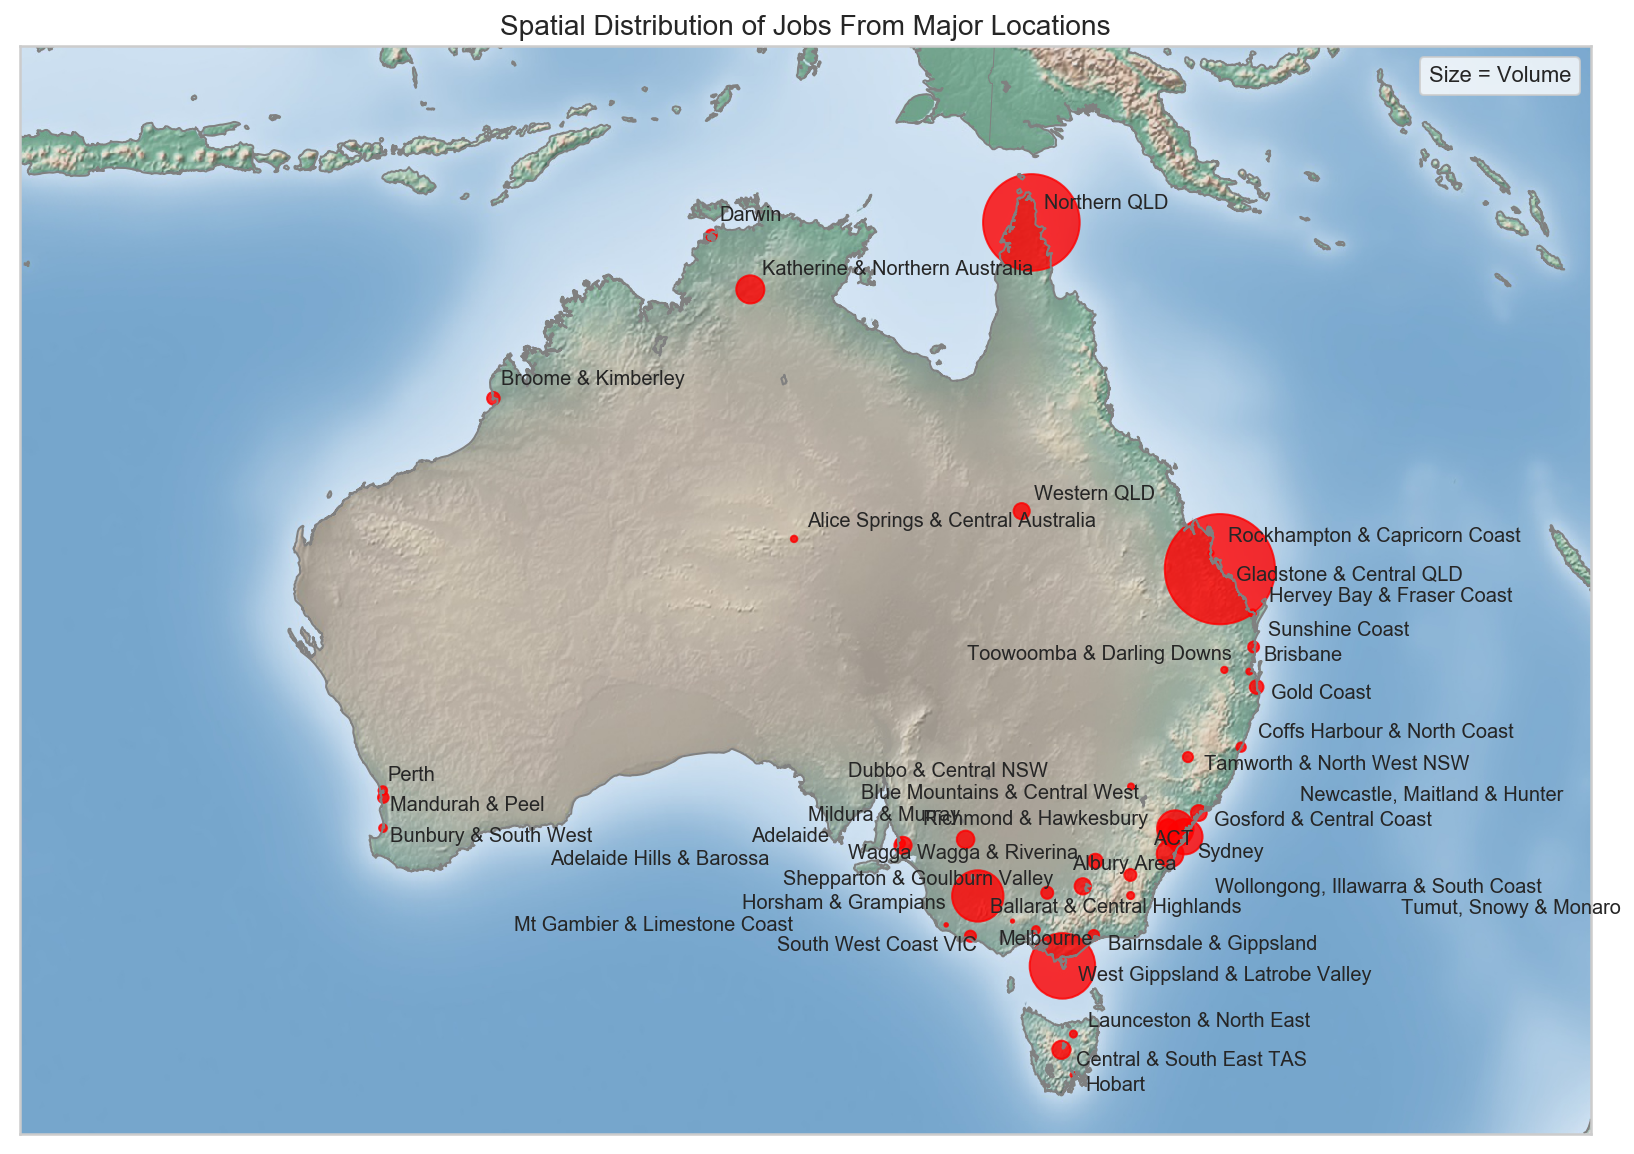

In [77]:
geolocator = Nominatim(user_agent='Big_Data_Assignment')
geolocator.geocode("Australia")

def geocode_no_timeout(address):
    try:
        return geolocator.geocode(address)
    except GeocoderTimedOut:
        return geocode_no_timeout(address)
    
# Get list of locations
df_locations = pd.DataFrame(columns=['Location', 'Latitude', 'Longitude'])
location_list = df[df['Location'].isna() == False]['Location'].unique()
location_cnts = df[df['Location'].isna() == False].groupby('Location').count()['Title']

missing = []
for location in location_list:
    coordinates = geocode_no_timeout(location)
    if (coordinates):
        df_locations.loc[len(df_locations.index)] = [location,coordinates.latitude,coordinates.longitude]
    else:
        missing.append(location)

# Append job counts
df_locations['Count'] = df[(df['Location'].isna() == False) & ~(df['Location'].isin(missing))].groupby('Location').count()['Title'].values

# Remove incorrect locations
df_locations = df_locations[df_locations['Latitude'] < 0]

# Visualise
fig = plt.figure(figsize=(20, 10))
aus_map = Basemap(projection='lcc', resolution='i', lat_0=-25.6, lon_0=134.35, width=6.5E6, height=4.5E6)
aus_map.shadedrelief()
aus_map.drawcoastlines(color='gray')
aus_map.drawcountries(color='gray')

# Convert coordinates from global to local and plot with labels
x, y = aus_map(df_locations['Longitude'].values,df_locations['Latitude'].values)
plt.scatter(x,y,s=df_locations['Count']/20,marker='o',c='red',alpha=0.8)
text = [plt.text(x[i] * (1 + 0.01), y[i] * (1 + 0.01) , df_locations['Location'].values[i], fontsize=10) for i in range(len(x))]
adjust_text(text)
plt.title('Spatial Distribution of Jobs From Major Locations',size=14)
legend = plt.legend(['Size = Volume'],handlelength=0,handletextpad=0,fancybox=True)
legend.legendHandles[0].set_visible(False)
plt.show()

The above map plots the distribution of most of the jobs according to location.  Not all are included because some locations were too general to be converted into appropriate latitudes and longitudes.  The size of the radius of each point is proportional to the volume of job postings produced from that location.

An obvious observation can be made from the map that most of the jobs come from coastal areas with very few originating inland.  This can be used as a somewhat reasonable indicator of the population density, and where a lot of the population is concentrated.  It should be noted however that some locations are more general than others, and include regions as well as cities.  This means that locations like Northern QLD end up with less than ideal placement on the map, and should be used as a general visual indication rather than for any substantial analytical purposes.

## 1. Extract relevant information to describe jobs' attributes
### 1.1 What are the classification and sub-classifications of each job
* Because we're doing analysis on classification and sub-classifications, we should drop all the missing values from Classification and Sub-Classification columns

In [9]:
# Removing all the missing rows for classifications and sub-classifications
df_classification = df[df['Classification'].isna()==False]
df_classification.shape

(197229, 12)

* Numbers of Job Postings per Classification

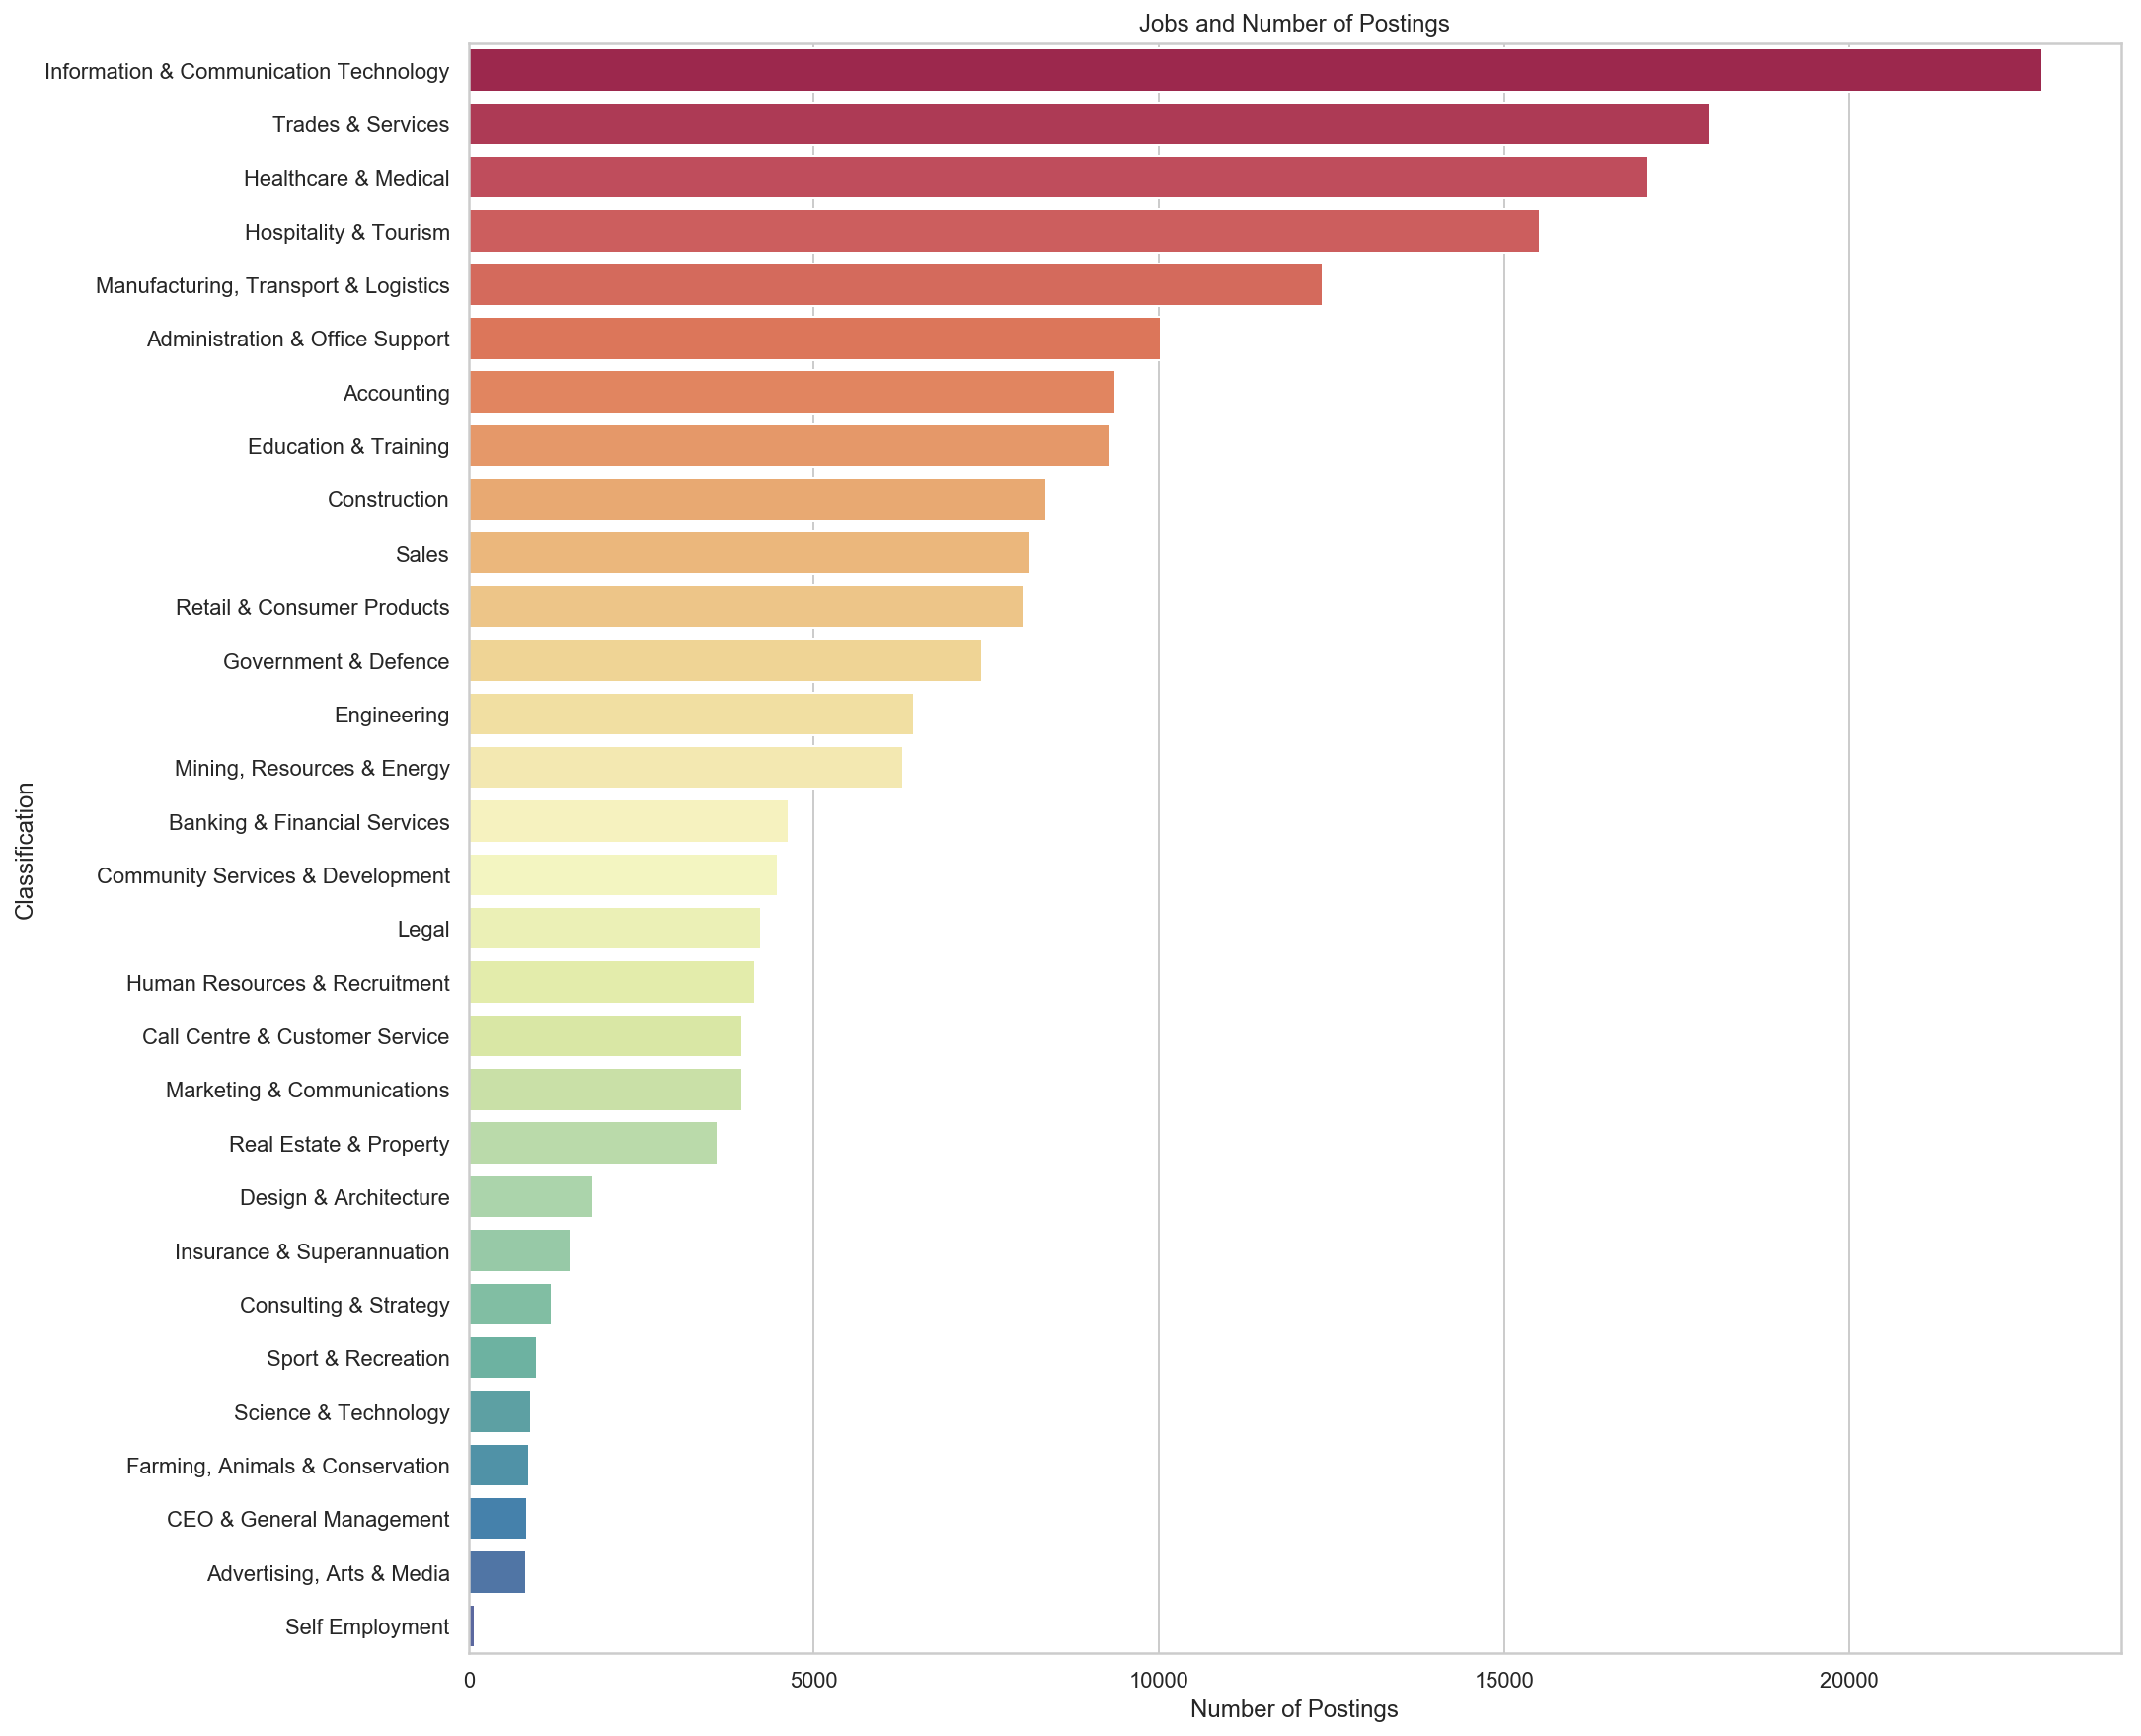

In [10]:
plt.figure(figsize=(15,15))
sns.countplot(y='Classification',data=df_classification,palette='Spectral',order=df_classification.Classification.value_counts().index)
# df_classification['Classification'].value_counts().hist()
plt.title('Jobs and Number of Postings')
plt.xlabel('Number of Postings')
plt.show()

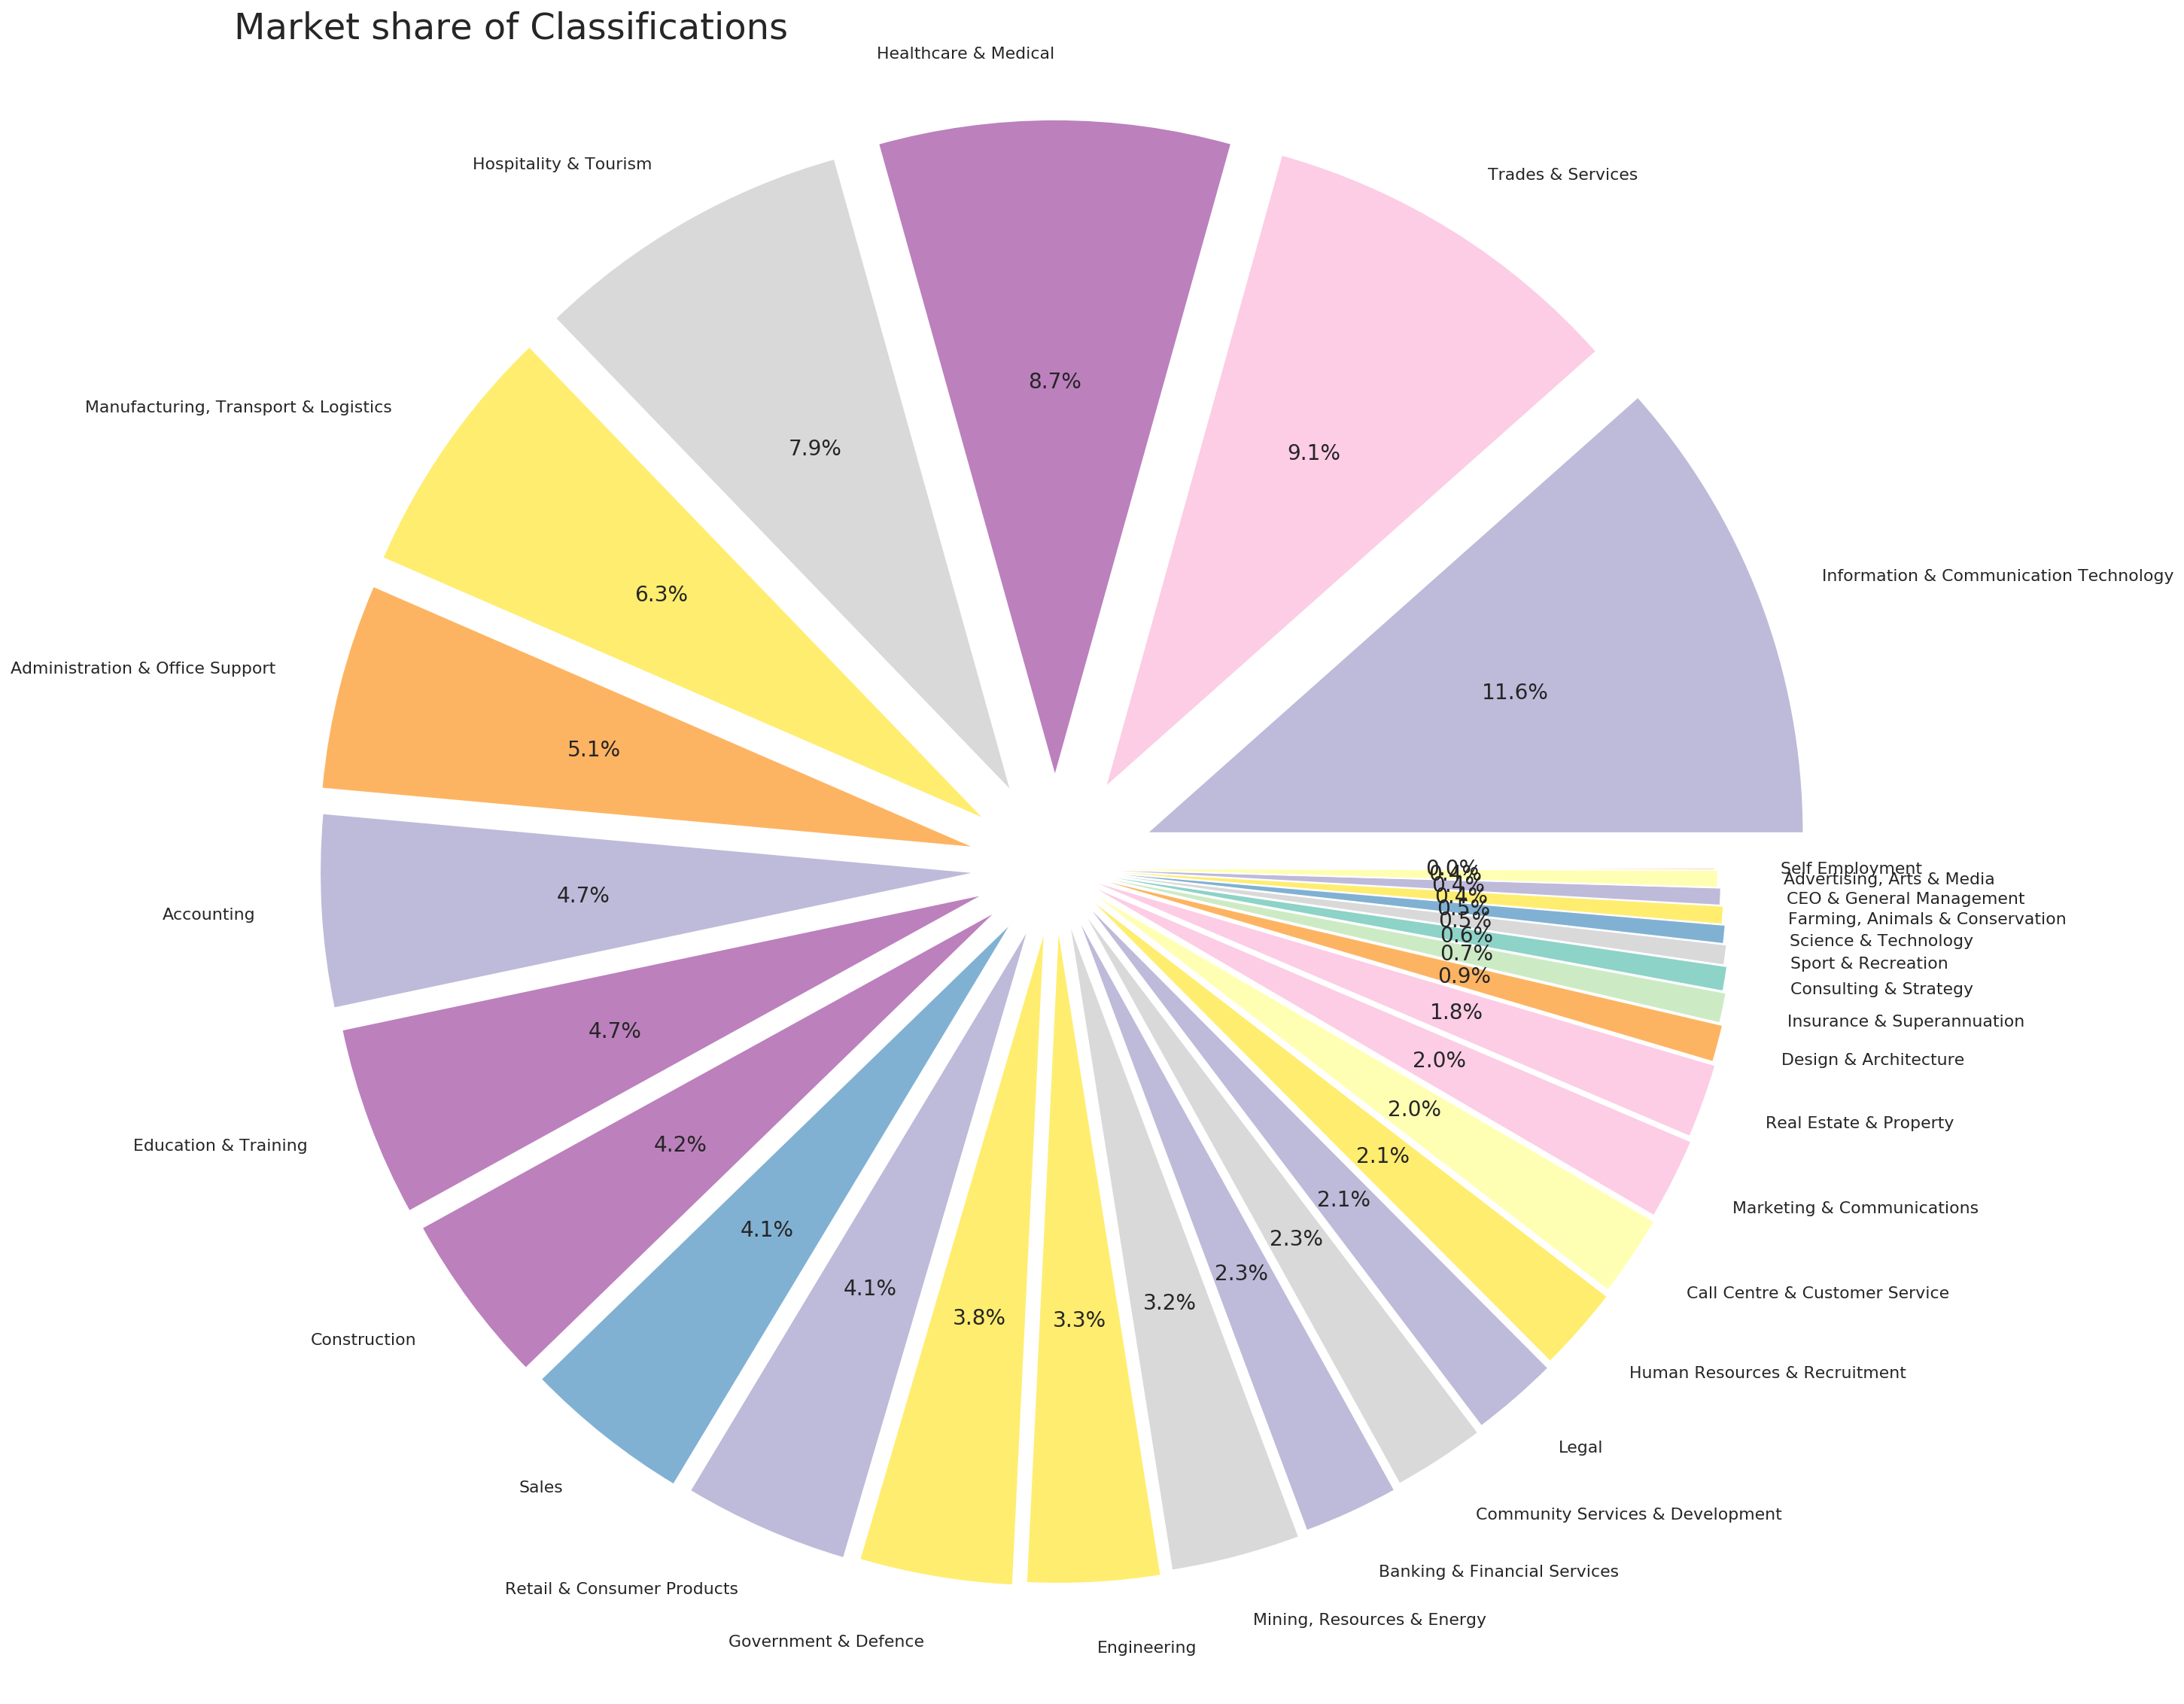

In [11]:
# Pie char for job market share of classifications
font = {'family' : 'normal',
        'size'   : 14}

plt.rc('font', **font)
df_pie = df_classification['Classification'].groupby(df_classification['Classification'])

explode = [0.15-x*0.005 for x in range(len(df_pie))]
cs = cm.Set3( np.random.rand(len(df_pie)) )


df_pie.count().sort_values(ascending=False).plot.pie(title="",explode=explode,colors=cs, figsize=(20,20),autopct='%1.1f%%')

plt.tight_layout()
plt.title('Market share of Classifications',size=24,loc='left')
plt.ylabel('')
plt.show()

### Observation
* So IT has the most job postings with around 20000 job postings, which takes up 12% of the market
* Top on demand jobs are IT, Trades & Services, Healthcare & Medical, Hospitality & Tourism

* Numbers of Sub-classifications per Classification

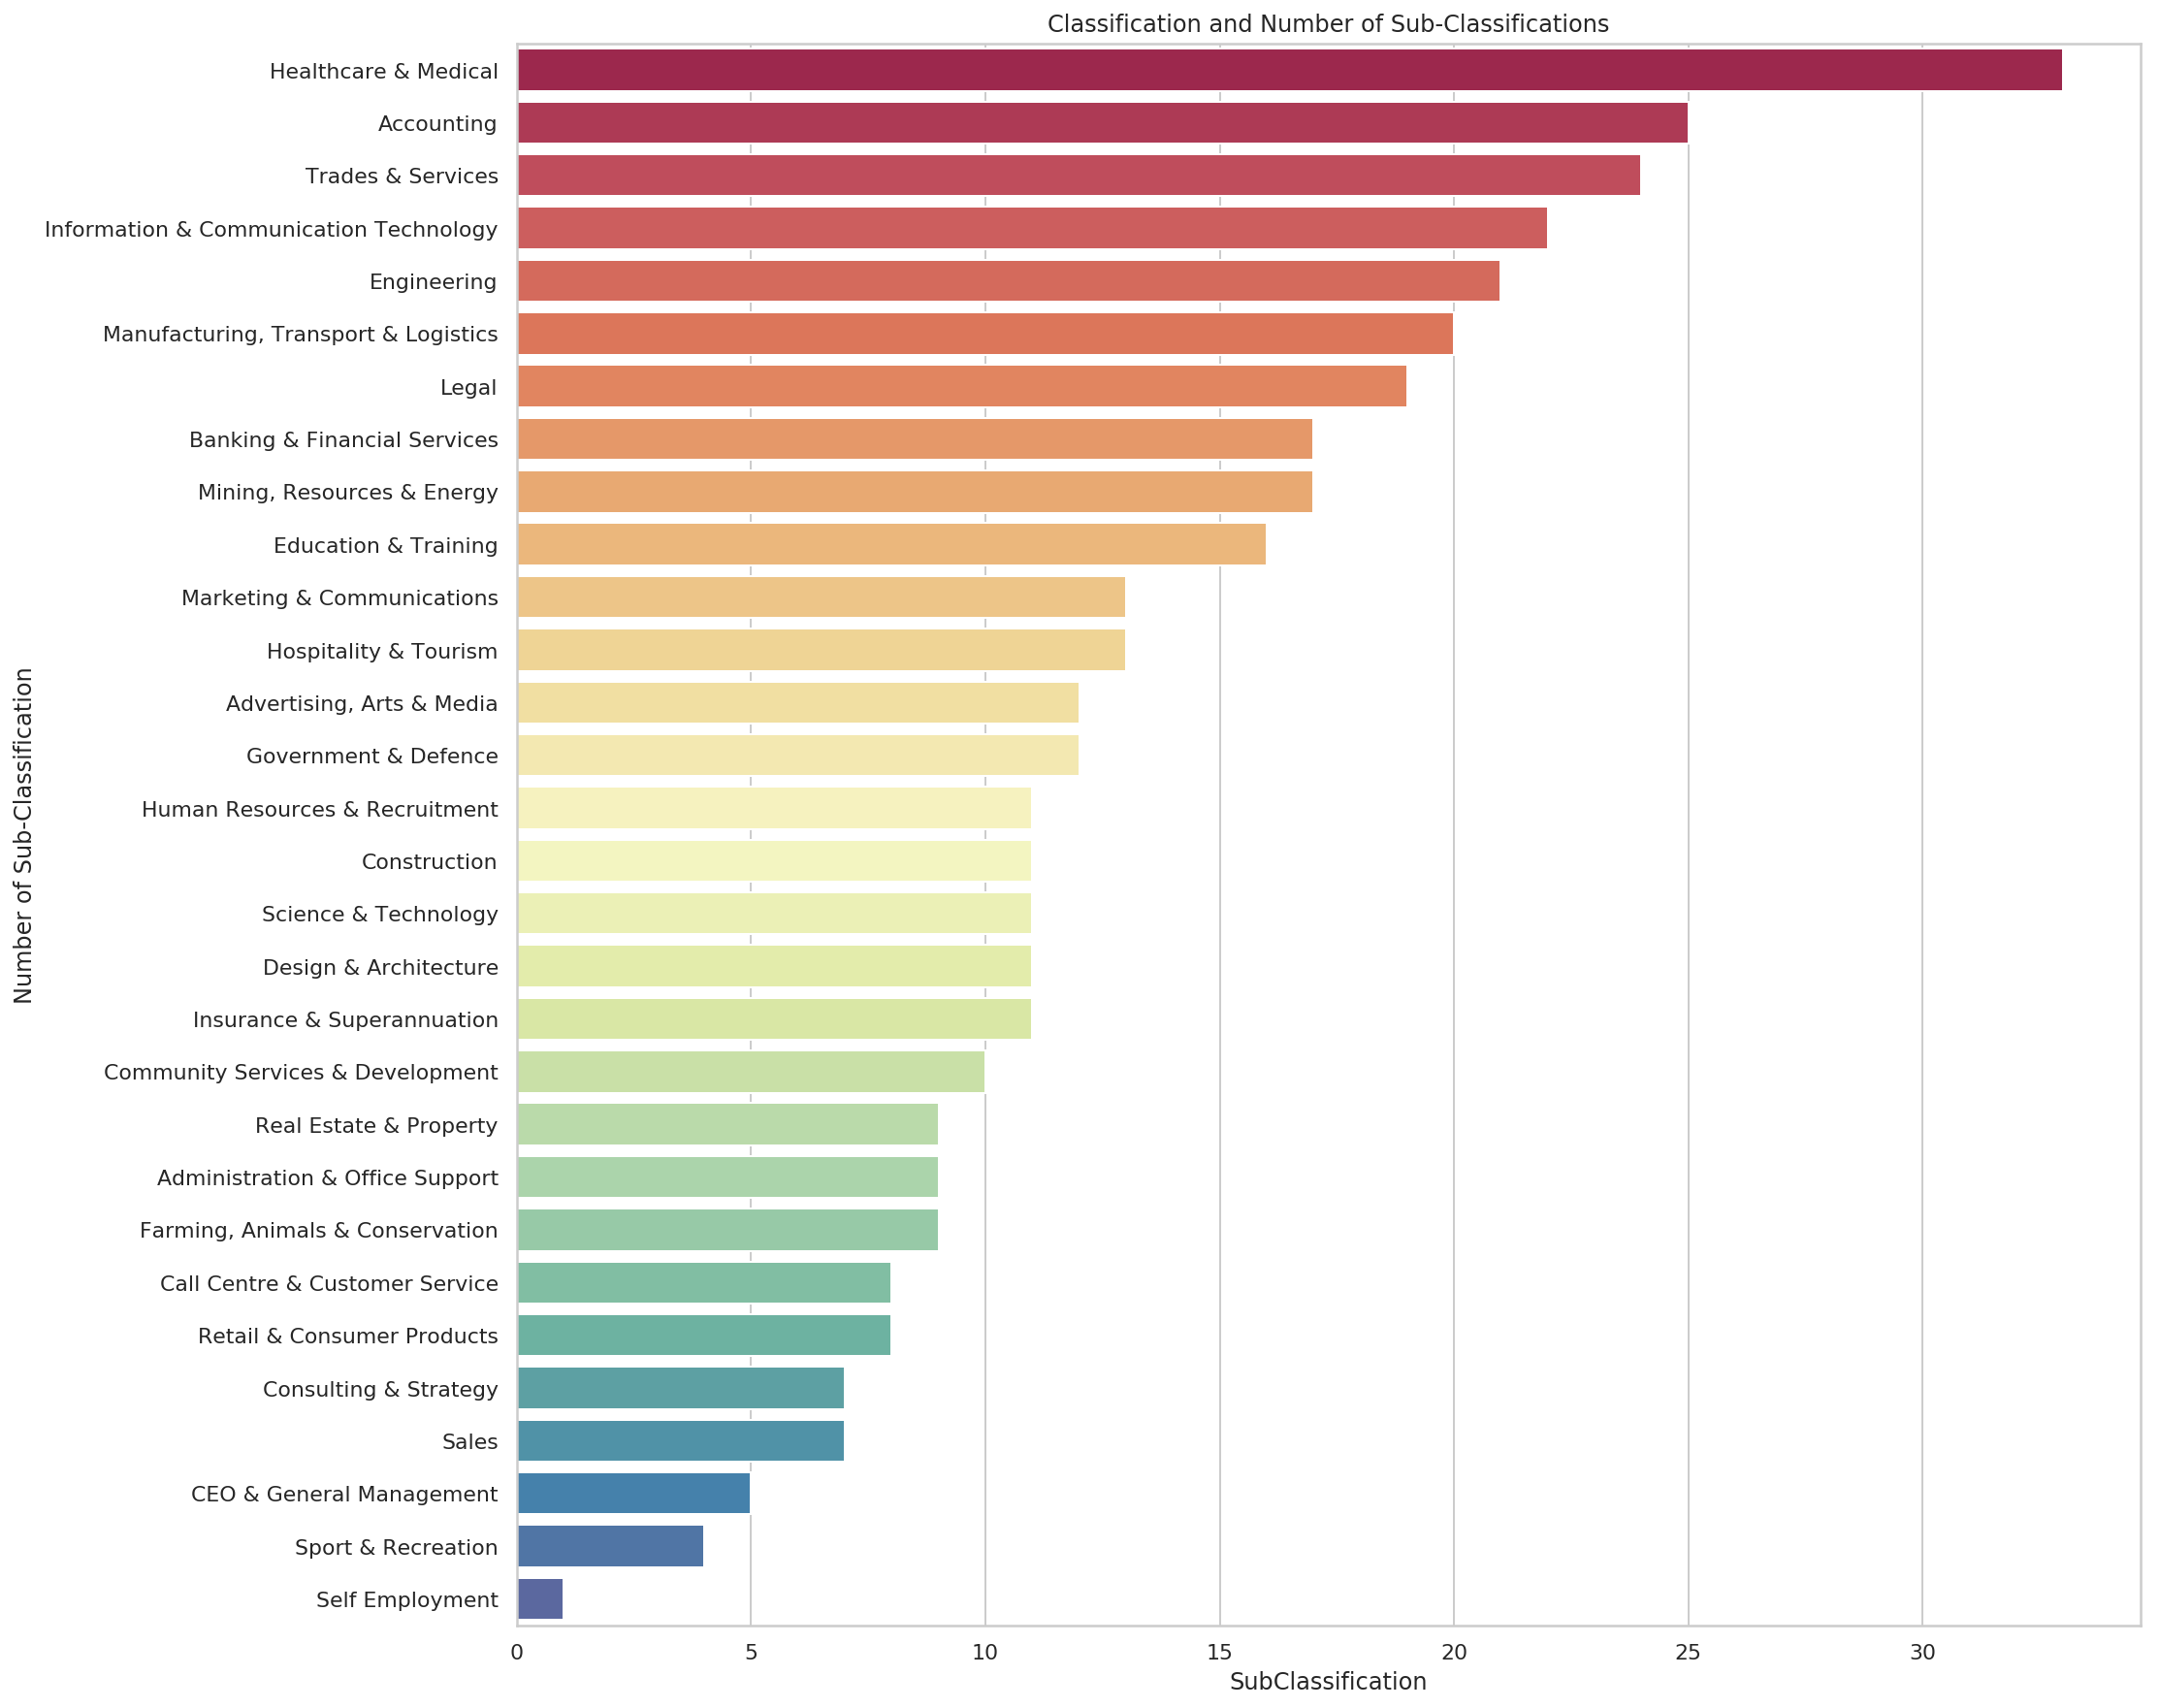

In [12]:
temp = pd.DataFrame(df_classification.groupby(['Classification'])['SubClassification'].value_counts())
temp = temp['SubClassification'].groupby(['Classification']).count()
temp = pd.DataFrame(temp.reset_index())

plt.figure(figsize=(15,15))
sns.barplot(x='SubClassification',y='Classification',data=temp.sort_values(by=['SubClassification'],ascending=False),palette='Spectral')
plt.title('Classification and Number of Sub-Classifications')
plt.ylabel('Number of Sub-Classification')
plt.show()

### Observation
* Top 5 with the most subclassifications are Healthcare, Accounting, Trades and Services, IT, and Engineering
* Bottoms are Self Employment, Sport and Recreation, CEO & Management, and Sales

* Looking at the top 4 classifications and their portions of sub classifications

In [13]:

# Get a list of Classifications sorted
list_of_class = df_classification.groupby('Classification').count().reset_index().sort_values(by=['Title'],ascending=False)['Classification'].tolist()
# Get interactive
def update(List):
    fig = plt.figure(figsize=(14,14))
    axs = fig.add_subplot(111)
    
    temp = df_classification[df_classification['Classification']==List].groupby(['SubClassification']).count().reset_index().sort_values(by='Title',ascending=False)
    explode = [0.1-x*0.005 for x in range(len(temp))]
    cs1 = cm.Set1( np.random.rand(len(temp)) )
    p,texts, autotexts = axs.pie(temp['Title'],colors=cs1,explode=explode,labels=temp['SubClassification'],wedgeprops={'alpha':0.7},autopct='%1.1f')
    axs.title.set_text(List)
    axs.title.set_size(20)

    for t in texts:
        t.set_color('grey')
    for t in autotexts:
        t.set_color('grey')
        t.set_size(12)
interact(update,List=list_of_class)

interactive(children=(Dropdown(description='List', options=('Information & Communication Technology', 'Trades …

<function __main__.update(List)>

### Top subclassification in each classification
* IT: Developers, Business/Systems Analysts, Project Management
* Trades & Services: Car trading, Electricians, Labourers
* Healthcare & Medical: Nursing - Aged Care, Physiotherapy, GP
* Hopitality: Chefs/Cooks, Waiting Staff, Bar & Beverage Staff


### Classification and Top 20 Companies

In [16]:
df_companies = df_classification[df_classification['Company'].isna()==False]

# Get a list of Classifications sorted
list_of_class = df_classification.groupby('Classification').count().reset_index().sort_values(by=['Title'],ascending=False)['Classification'].tolist()

# Get interactive
def update(List):
    fig = plt.figure(figsize=(14,14))
    axs = fig.add_subplot(111)
    
    temp = df_companies[df_companies['Classification']==List].groupby(['Company']).count().reset_index().sort_values(by='Title',ascending=False)[:20]
    explode = [0.1-x*0.005 for x in range(len(temp))]
    cs1 = cm.Set1( np.random.rand(len(temp)) )
    p,texts, autotexts = axs.pie(temp['Title'],colors=cs1,explode=explode,labels=temp['Company'],wedgeprops={'alpha':0.7},autopct='%1.1f')
    axs.title.set_text(List)
    axs.title.set_size(20)


    for t in texts:
        t.set_color('grey')
    for t in autotexts:
        t.set_color('grey')
        t.set_size(12)
        
interact(update,List=list_of_class)

interactive(children=(Dropdown(description='List', options=('Information & Communication Technology', 'Trades …

<function __main__.update(List)>

### Observations:
* In IT field, Paxus leads the way with job postings
* Sugarman Australia is the top recruiter in Healthcare & Medical
* Hays recruitment agency posts a lot of jobs

### 1.2 Location of the job



In [17]:
# Removing all the missing rows for locations
df_location = df[df['Location'].isna()==False]
df_location.shape

(197229, 12)

* Number of Job per locations

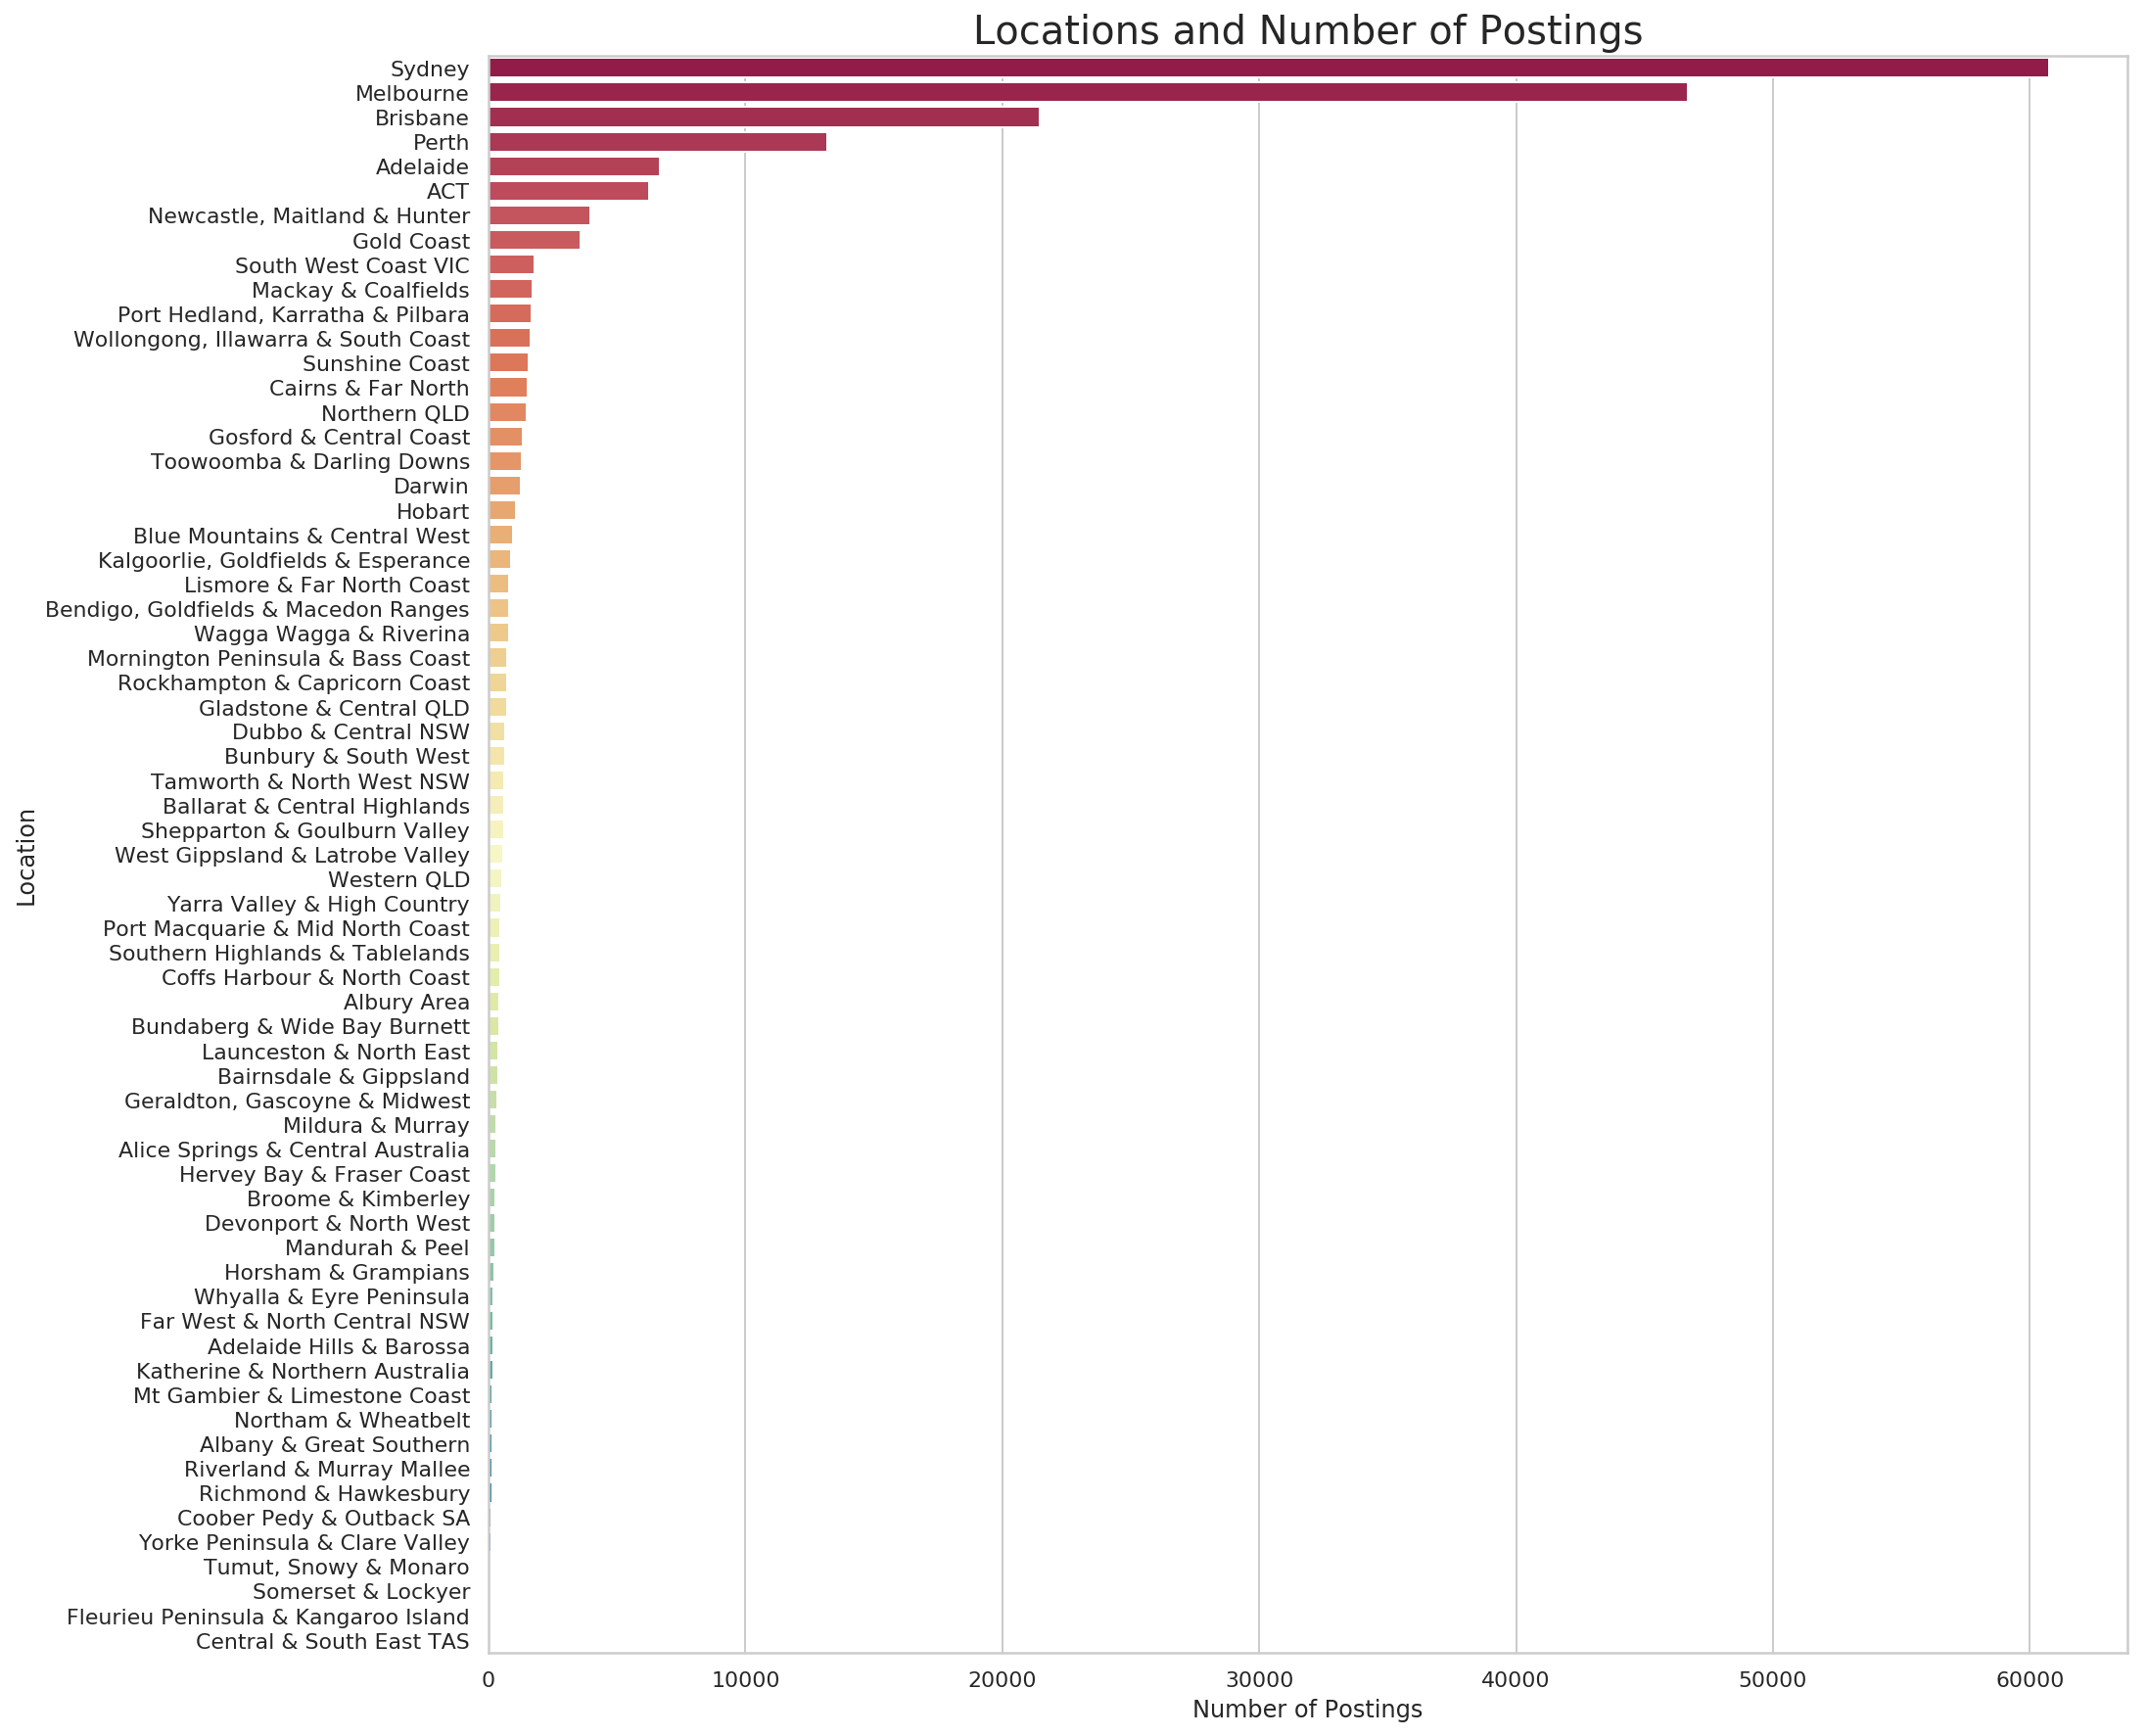

In [18]:
plt.figure(figsize=(15,15))
sns.countplot(y='Location',data=df_location,palette='Spectral',order=df_location.Location.value_counts().index)
plt.title('Locations and Number of Postings',size=20)
plt.xlabel('Number of Postings')
plt.show()



### Observation
* Sydney has the most job postings more than 60000
* The next cities are (in order) Melbourne, Brisbane, Perth, Adelaide, ACT

#### Now let's look at the Classifications for the top cities

In [19]:
# Get a list of Locations sorted by the number of job postings
list_of_class = df_classification.groupby('Location').count().reset_index().sort_values(by=['Title'],ascending=False)['Location'].tolist()
# Get interactive
def update(Location):
    fig = plt.figure(figsize=(14,14))
    axs = fig.add_subplot(111)
    
    temp = df_location[df_location['Location']==Location].groupby(['Classification']).count().reset_index().sort_values(by='Title',ascending=False)

    explode = [0.1-x*0.005 for x in range(len(temp))]
    cs1 = cm.Set1( np.random.rand(len(temp)) )
    p,texts, autotexts = axs.pie(temp['Title'],colors=cs1,explode=explode,labels=temp['Classification'],wedgeprops={'alpha':0.7},autopct='%1.1f')
    axs.title.set_text(Location.upper())
    axs.title.set_size(20)


    
    for t in texts:
        t.set_color('grey')
    for t in autotexts:
        t.set_color('grey')
        t.set_size(12)
    plt.show()
interact(update,Location=list_of_class)

interactive(children=(Dropdown(description='Location', options=('Sydney', 'Melbourne', 'Brisbane', 'Perth', 'A…

<function __main__.update(Location)>

### Observation
* It is very interesting to see that while IT is in demand in the 3 big cities Melbourne, Sydney, and Brisbane, the top job in Gold Coast is Hopitality
* Hopitality & Tourism is in the second spot in Sydney and Melbourne, while it is in the 5th place in Brisbane
* When we look at ACT, of course the top 2 sectors are IT and Government & Defence

## 1.3 Classification vs Location
+ For each classification, which location has more job postings

In [20]:
# Get a list of Classifications sorted
list_of_class = df_classification.groupby('Classification').count().reset_index().sort_values(by=['Title'],ascending=False)['Classification'].tolist()
# Dataframe keeps a count of postings per location for each classification 
df_class_loc = df_location.groupby(df_location['Classification'])['Location'].value_counts().reset_index(name='count')


# Get interactive
def update(Location):
    fig = plt.figure(figsize=(14,14))
    axs = fig.add_subplot(111)
    
    temp = df_class_loc[df_class_loc['Classification']==Location]
    explode = [0.1-x*0.005 for x in range(len(temp))]
    cs1 = cm.Set1( np.random.rand(len(temp)) )
    p,texts, autotexts = axs.pie(temp['count'],colors=cs1,explode=explode,labels=temp['Location'],wedgeprops={'alpha':0.7},autopct='%1.1f')
    axs.title.set_text(Location.upper())
    axs.title.set_size(20)

    for t in texts:
        t.set_color('grey')
    for t in autotexts:
        t.set_color('grey')
        t.set_size(12)
    plt.tight_layout()
    plt.show()
interact(update,Location=list_of_class)

interactive(children=(Dropdown(description='Location', options=('Information & Communication Technology', 'Tra…

<function __main__.update(Location)>

### Observation:
+ If you need to find a job in the IT field, there are more job postings in Sydney, Melbourne, Brisbane, ACT, Perth, then Adelaide (in order from most to least)
+ Sydney dominates the job market with most job postings in the top fields
+ However Perth leads in Mining, Resource, and energy

## 1.4 Salary Range and Classification

In [21]:
# Get the average lowest and highest salaries within each sector
df_salaries = df.groupby('Classification').mean().reset_index()

# Split off into a new dataframe
df_lowest = df_salaries[['Classification', 'LowestSalary']]
df_highest = df_salaries[['Classification', 'HighestSalary']]

# Label for each location salary whether it represents average highest or lowest
df_lowest['Salary Bounds'] = 'Lowest'
df_highest['Salary Bounds'] = 'Highest'

# Rename columns
df_lowest.columns = ['Classification', 'AverageSalary', 'Salary Bounds']
df_highest.columns = ['Classification', 'AverageSalary', 'Salary Bounds']

# Combine into single dataframe
df_salaries = df_highest.append(df_lowest).reset_index(drop=True)

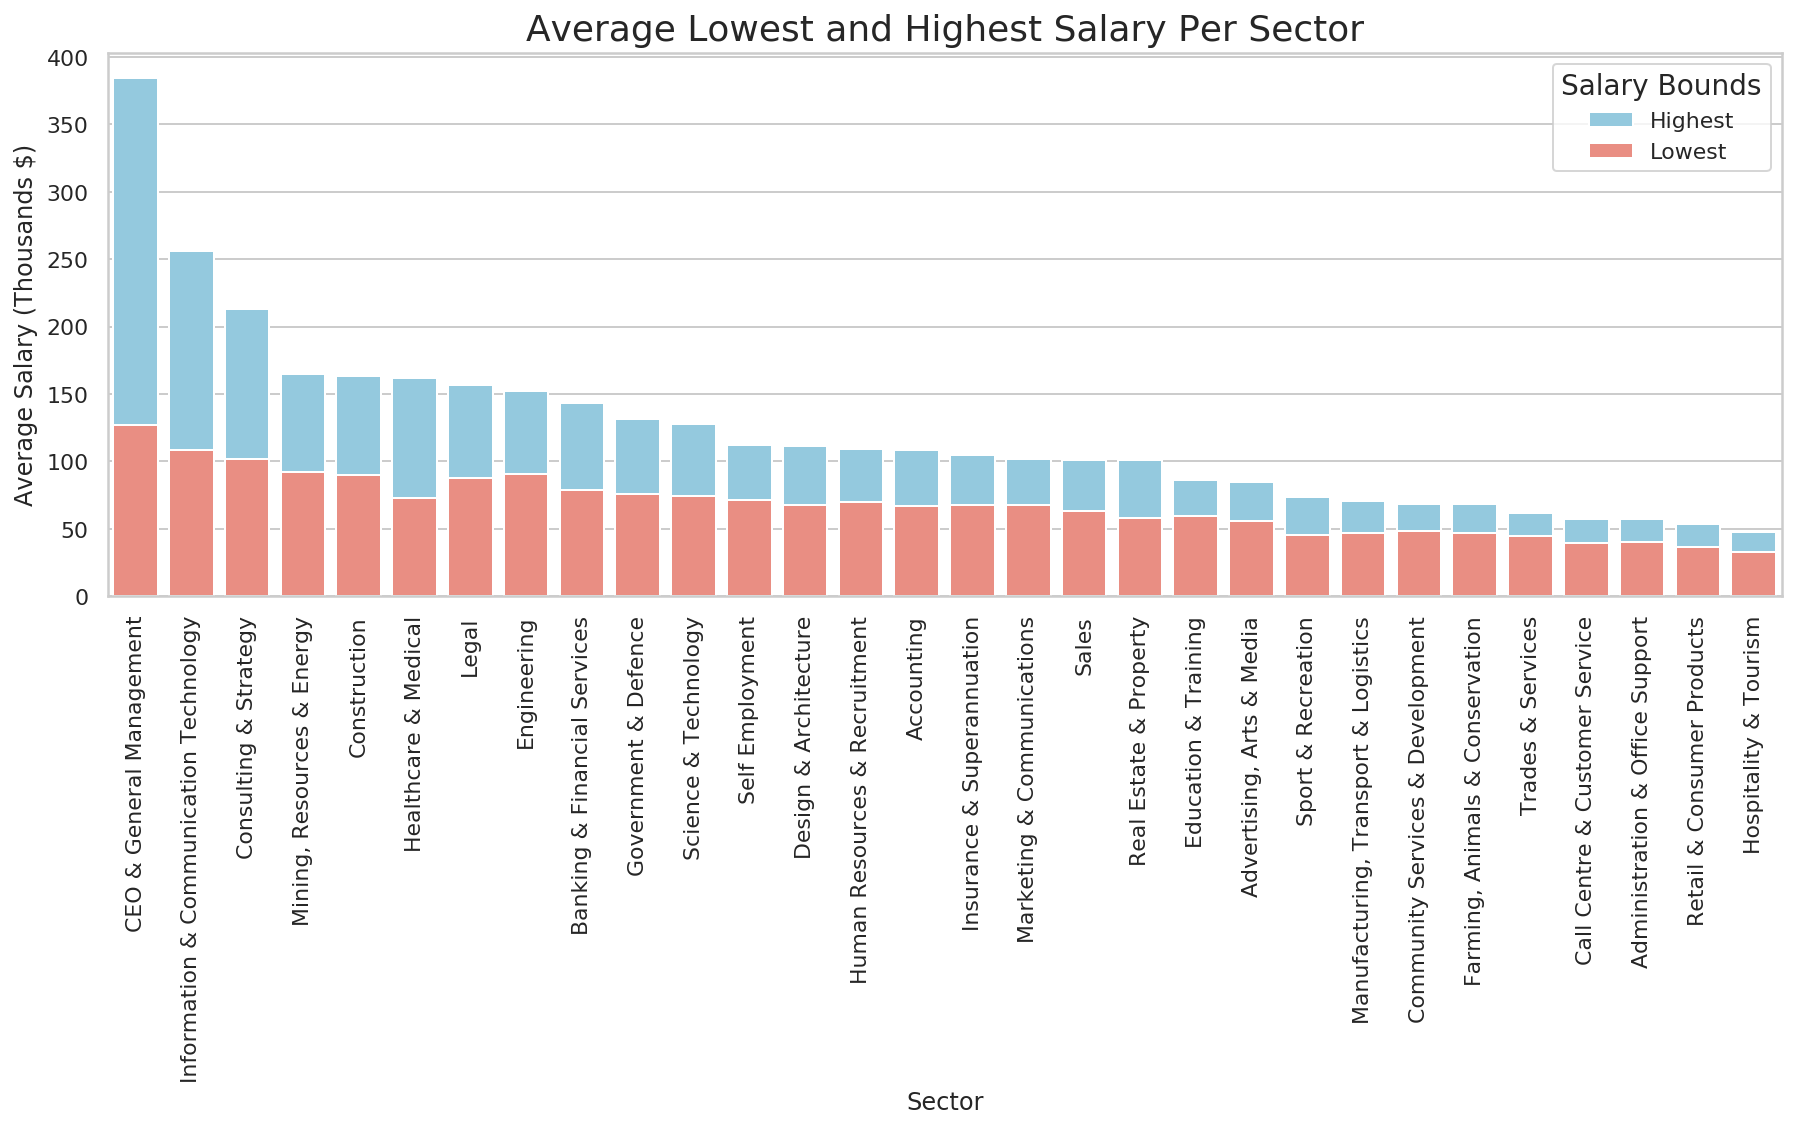

In [22]:
# Sort values and plot
df_salaries.sort_values(by='AverageSalary',ascending=False,inplace=True)

plt.figure(figsize=(15,5))
plt.title('Average Lowest and Highest Salary Per Sector',size=18)
bar_plt = sns.barplot(x='Classification', y='AverageSalary', hue='Salary Bounds', palette=['skyblue','salmon'], data=df_salaries, dodge=False)
bar_plt.set_xticklabels(bar_plt.get_xticklabels(),rotation=90)
bar_plt.set_xlabel('Sector')
bar_plt.set_ylabel('Average Salary (Thousands $)')
bar_plt.legend(title='Salary Bounds',frameon=True)

plt.show()

## 1.5 Salary Range and top 10 Classifications (in terms of number of jobs)

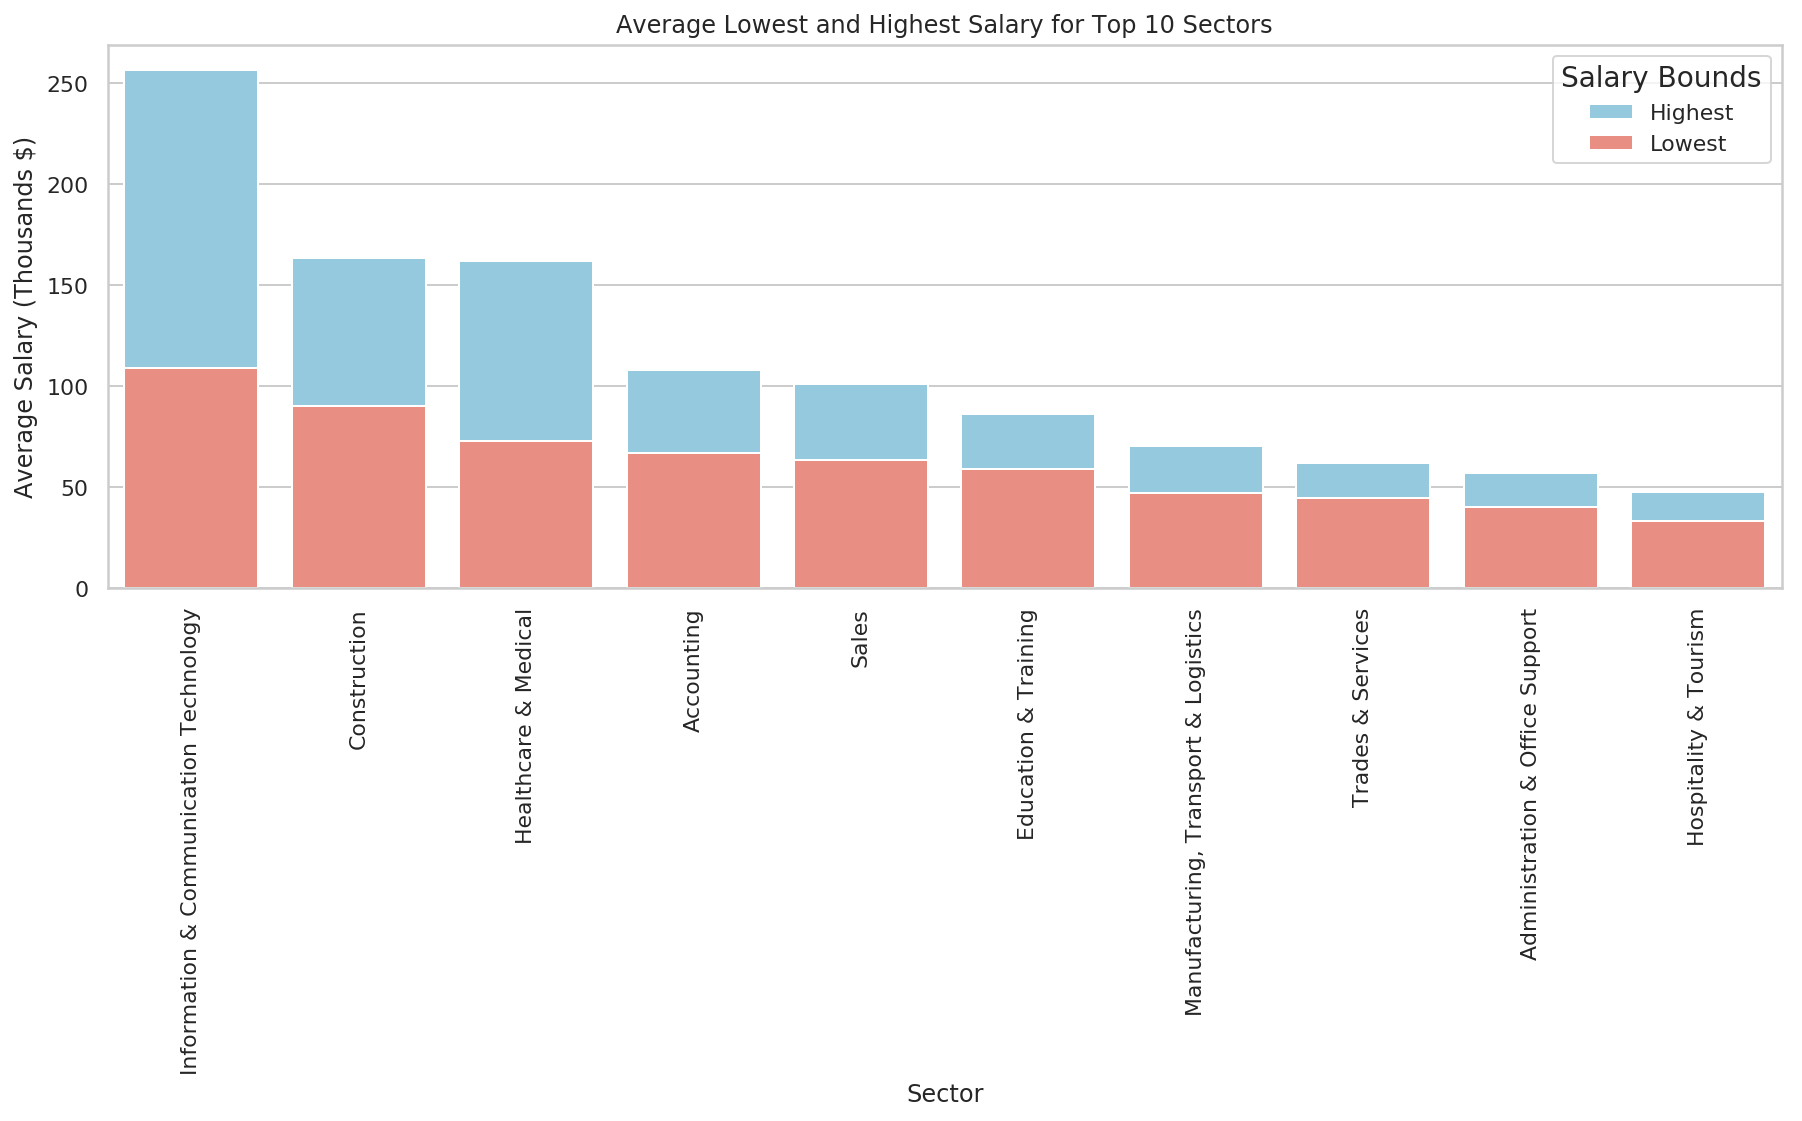

In [23]:
# Get a list of the job classifications
class_keys = df[df['Classification'].isna() == False]['Classification'].unique()

# Get proportion of market each classification has, as percentages
class_cnts = df.groupby('Classification').count()[['Title']].reset_index()
class_keys = class_cnts['Classification'].values
class_cnts = class_cnts['Title'].values
class_proportion = sorted(class_cnts/sum(class_cnts),reverse=True)
# Get a list of the top 5
class_sorted = sorted(zip(class_keys,class_cnts),key=lambda x: x[1], reverse=True)
class_sorted = [class_sorted[x][0] for x in range(len(class_sorted))]

# Get top 10 classifications and extract them from the previous dataframe
class_top_10 = class_sorted[:10]
df_top_10_salary = df_salaries[df_salaries['Classification'].isin(class_top_10)].sort_values(by='AverageSalary',ascending=False)

plt.figure(figsize=(15,5))
plt.title('Average Lowest and Highest Salary for Top 10 Sectors')
bar_plt = sns.barplot(x='Classification', y='AverageSalary', hue='Salary Bounds', palette=['skyblue','salmon'], data=df_top_10_salary, dodge=False)
bar_plt.set_xticklabels(bar_plt.get_xticklabels(),rotation=90)
bar_plt.set_xlabel('Sector')
bar_plt.set_ylabel('Average Salary (Thousands $)')
bar_plt.legend(title='Salary Bounds', frameon=True)

plt.show()

### Observations:

+ The sector with the greatest lowest and highest average salaries can be seen in the graph above, being CEO and General Management.  This is contrasted by it's job posting volume, being the third lowest of all other sectors.
+ The IT sector however is ranked second highest in terms of average lowest and highest annual salary, but is ranked highest in terms of job posting volume. IT is one of the best sectors to target for someone entering the job market, in terms of both job volume and average salary. 
+ Hospitality & Tourism industry is in top 10 for job postings but gets paid the least

## 1.6 Salary Range and Location

In [24]:
# Get the list of the top 20 locations with highest volume of jobs
df_top_20 = df_location.groupby(['Location']).count().reset_index().sort_values(by=['Title'],ascending=False)[:20]['Location'].tolist()
# df_location = df_location.sort_values(by=['Title'],ascending=False)[:20]['Location'].tolist()
# Finds top 20 locations into df_top_20
df_top_20 = df[df['Location'].isin(df_top_20)]

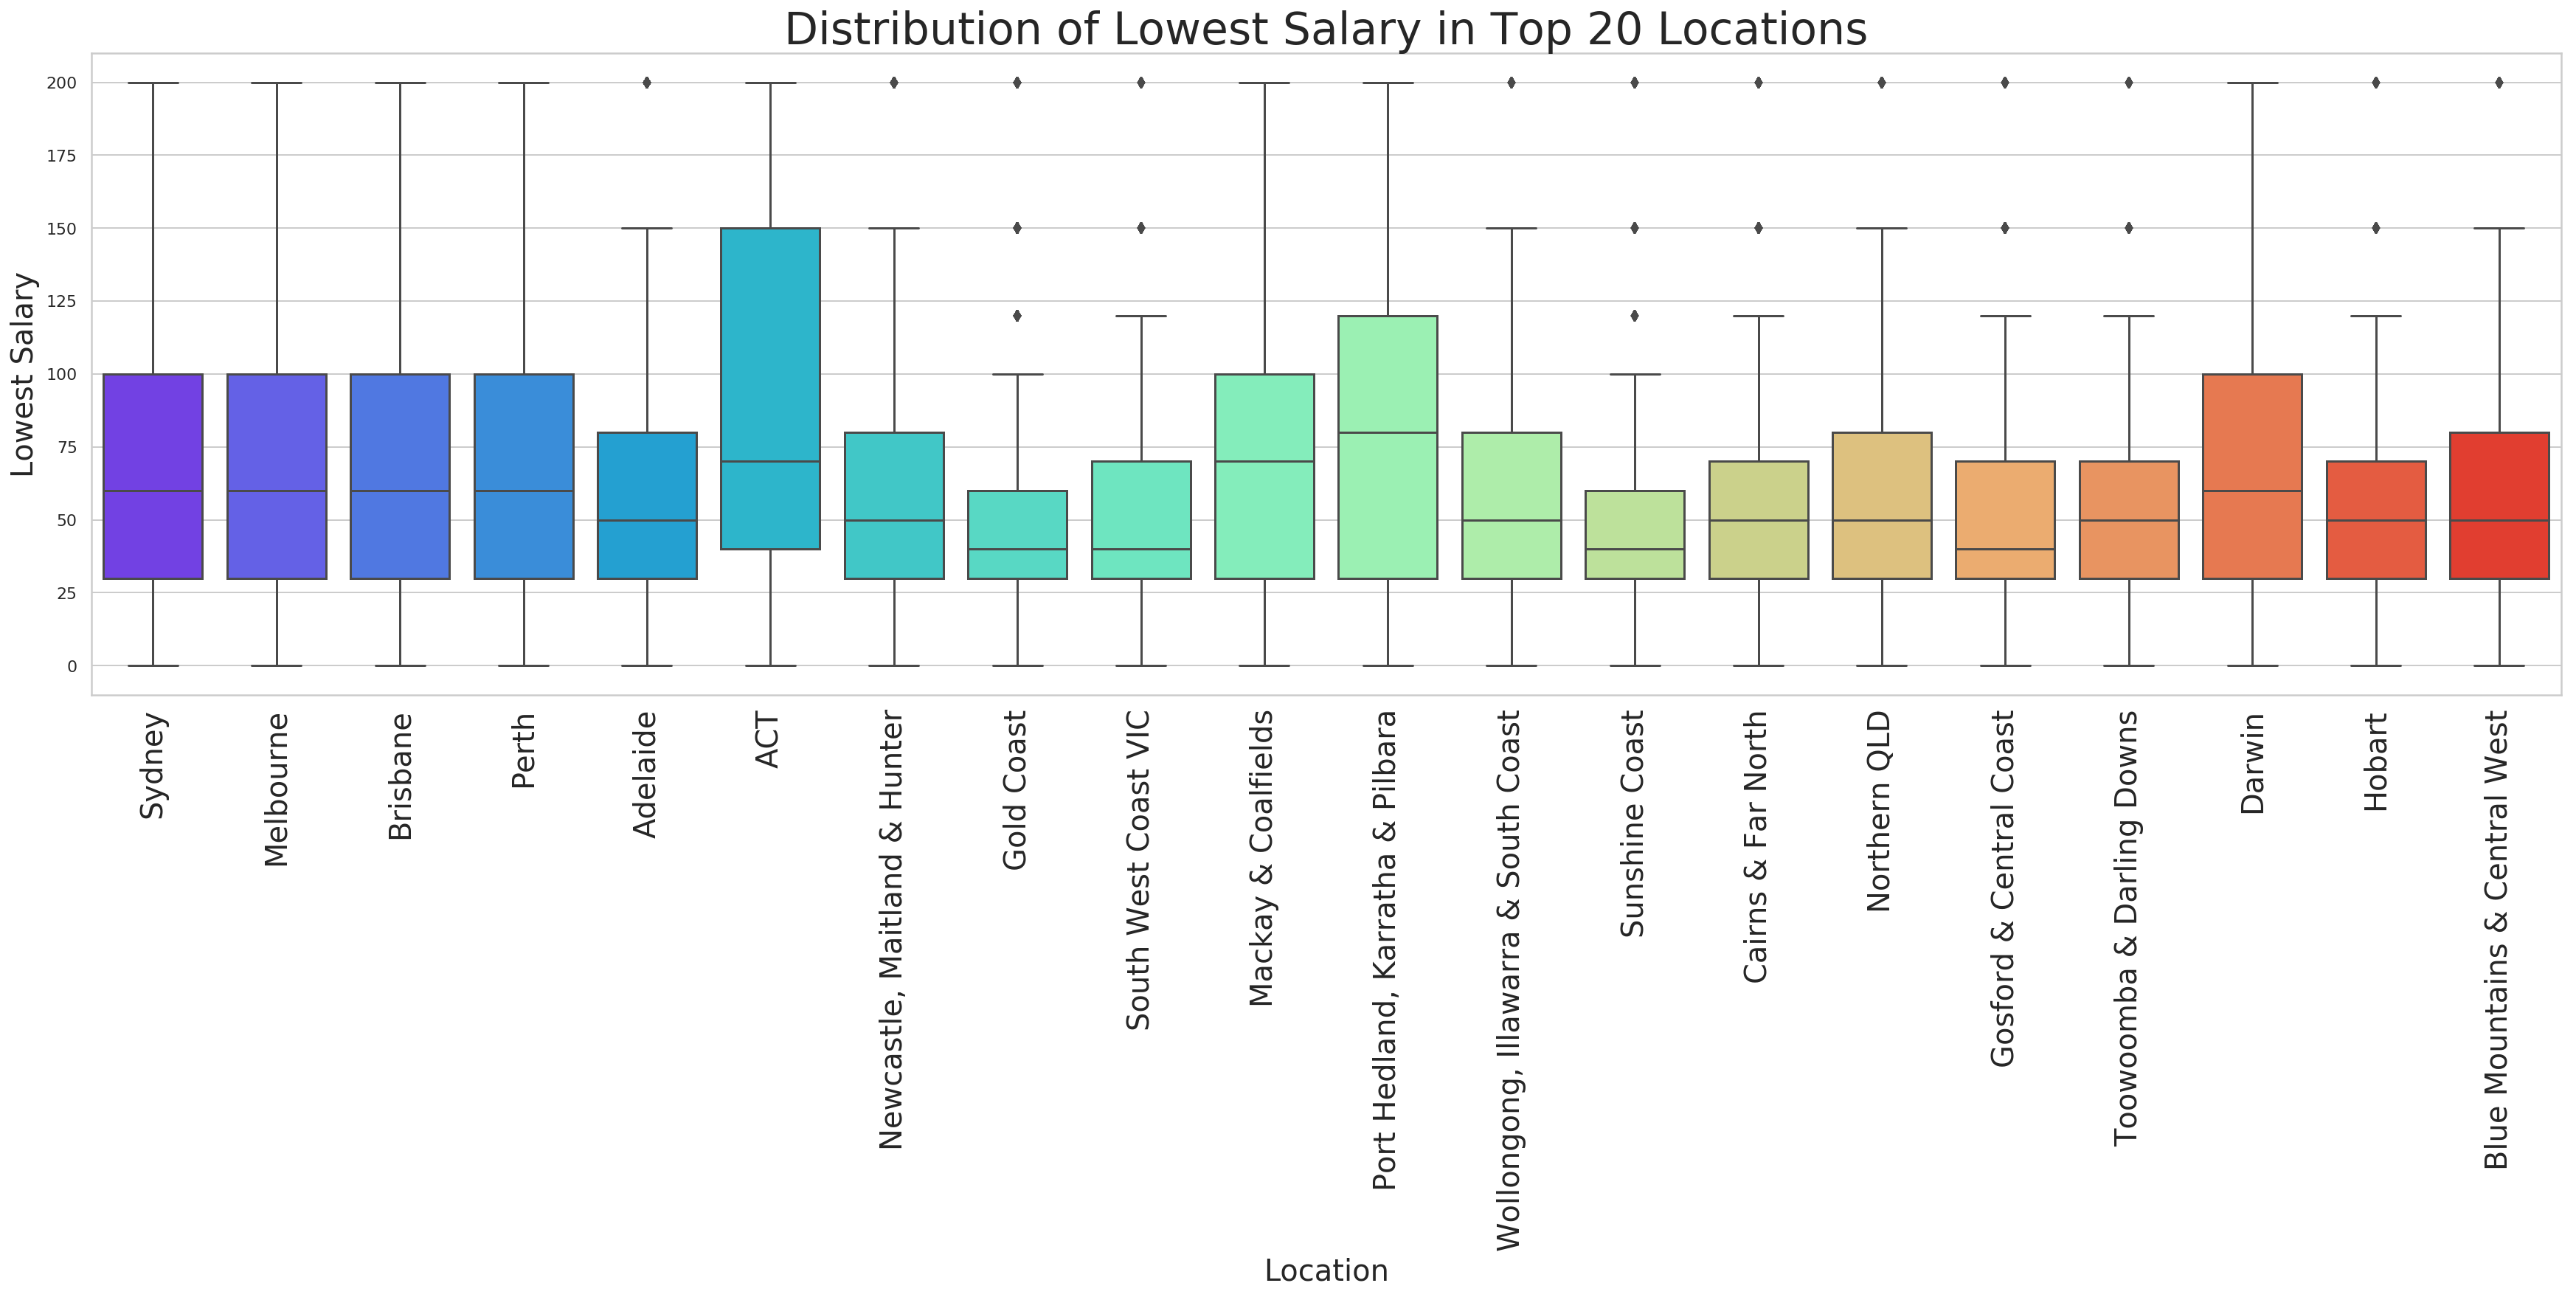

In [25]:
# Plot the distribution of lowest salaries by location
plt.figure(figsize=(30,8))

# plt.rcParams.update({'font.size': 30})

box_plt = sns.boxplot(x='Location',y='LowestSalary',data=df_top_20,order=df_top_20.Location.value_counts().index,palette='rainbow')
box_plt.set_xticklabels(box_plt.get_xticklabels(),rotation=90,fontsize=20)
plt.ylabel('Lowest Salary',fontsize=20)
plt.xlabel('Location',fontsize=20)


plt.title('Distribution of Lowest Salary in Top 20 Locations',size=30)
plt.show()

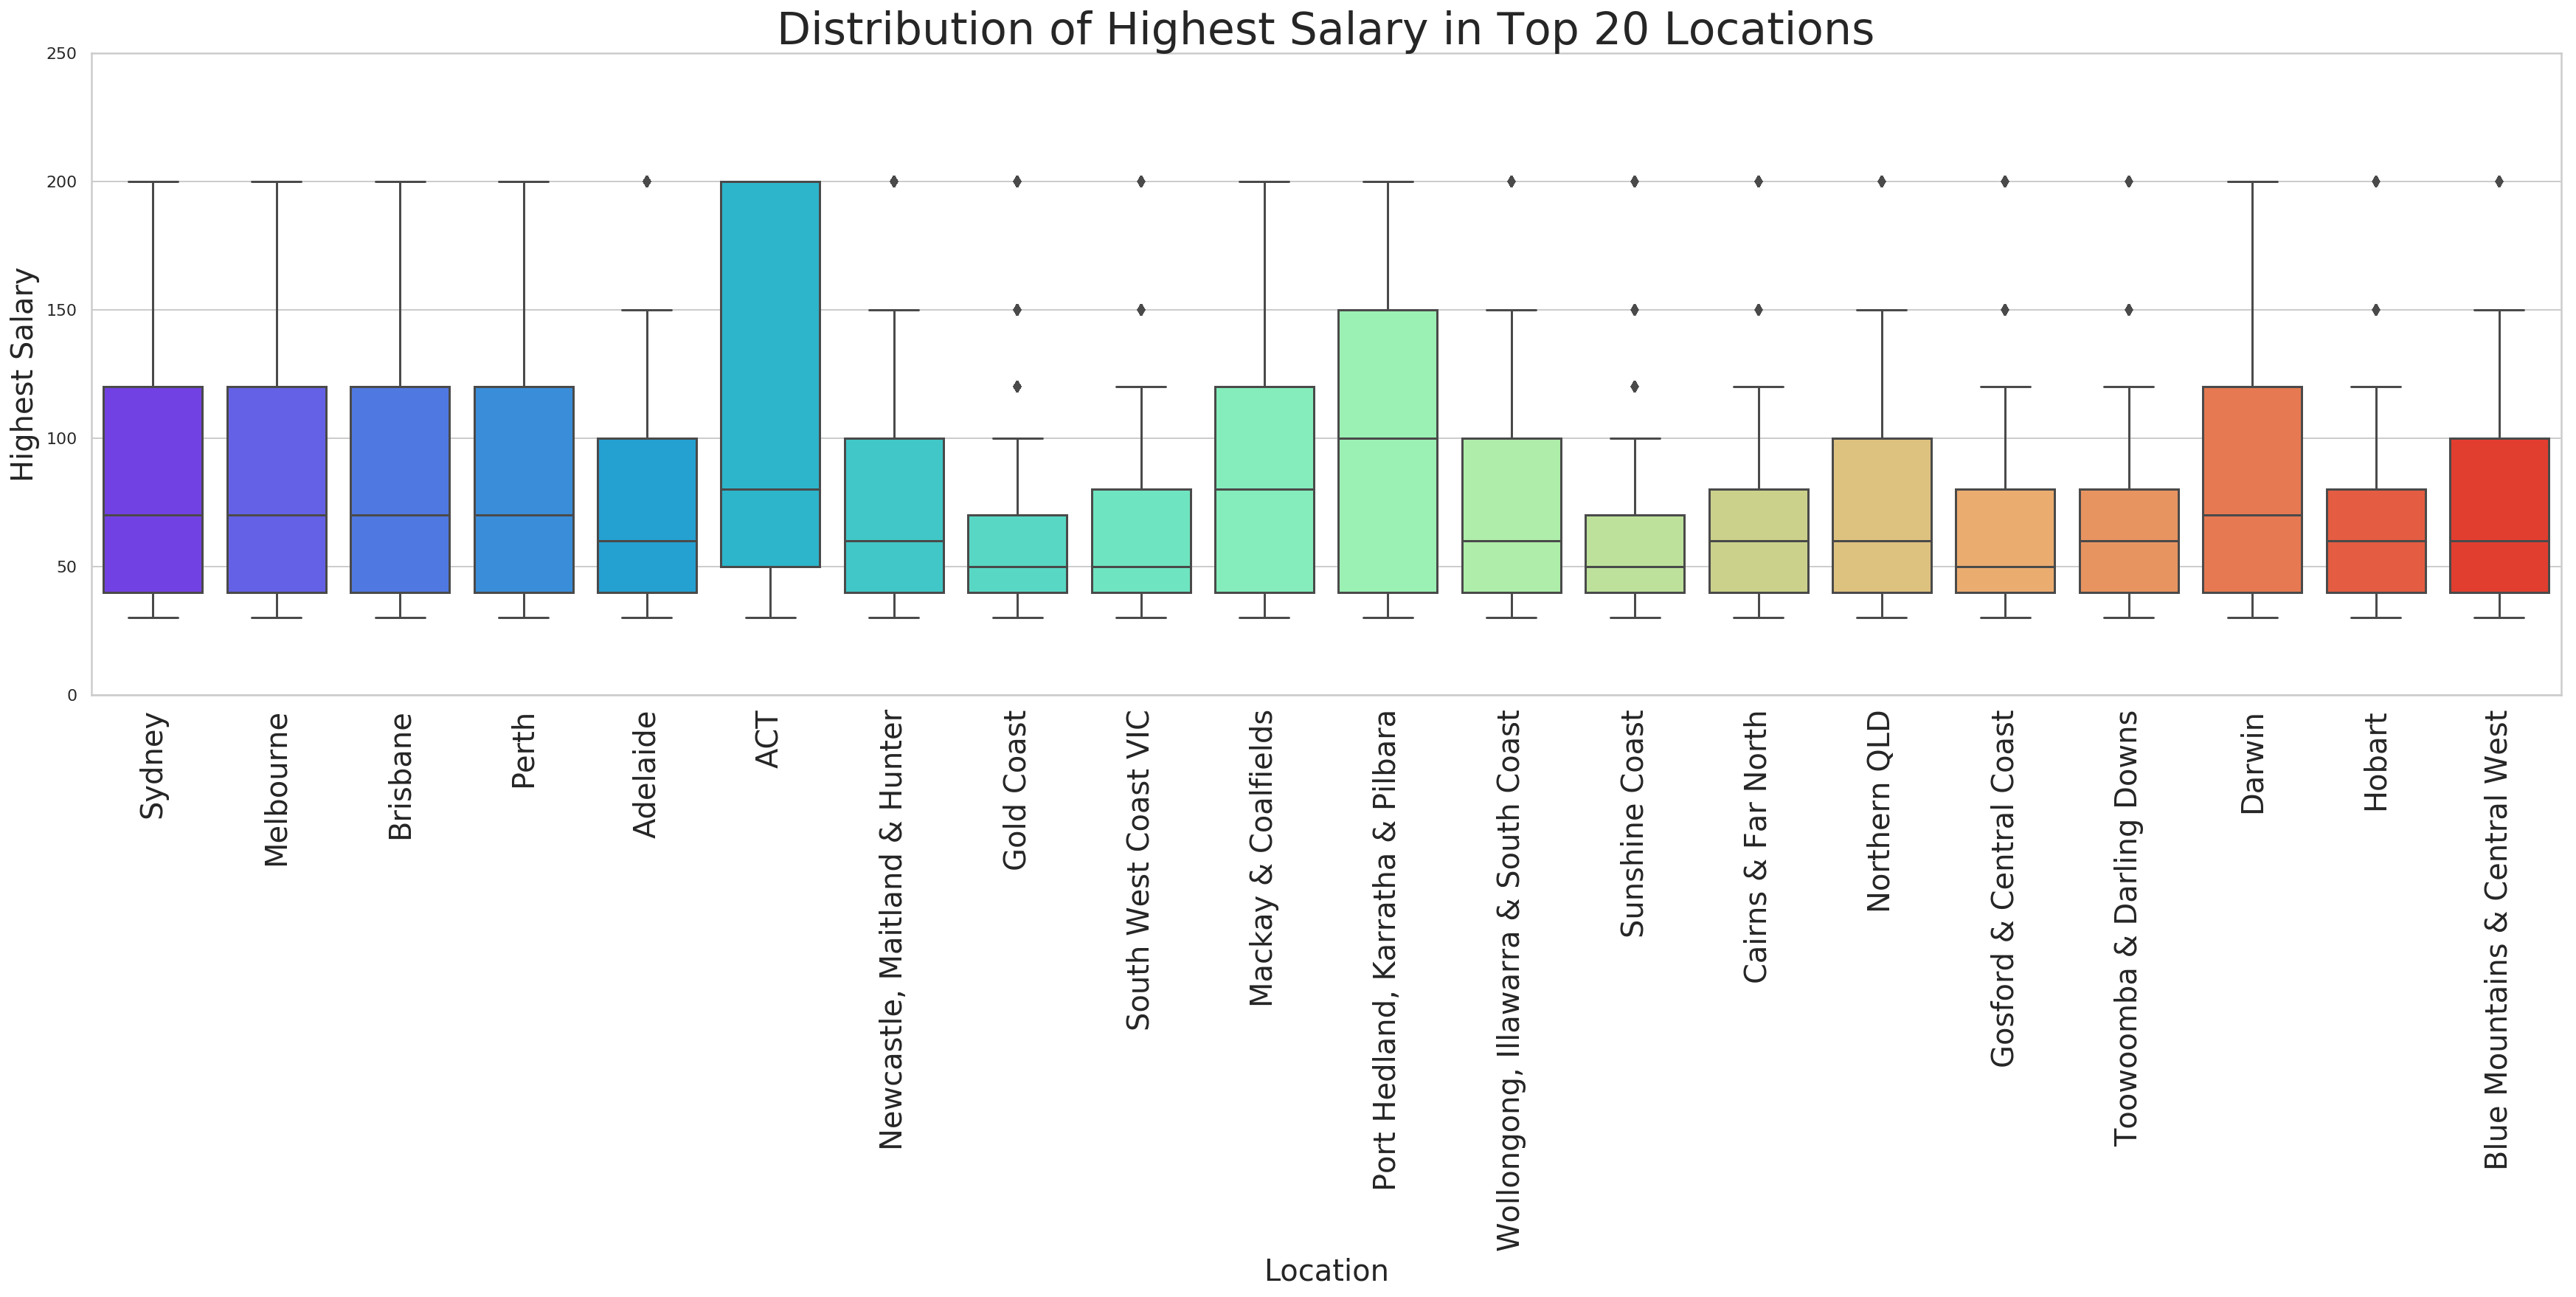

In [26]:
# Look at the distribution of highest salaries by location
plt.figure(figsize=(30,8))

box_plt = sns.boxplot(x='Location',y='HighestSalary',data=df_top_20,order=df_top_20.Location.value_counts().index,palette='rainbow')
box_plt.set_xticklabels(box_plt.get_xticklabels(),rotation=90,fontsize=20)
plt.title('Distribution of Highest Salary in Top 20 Locations',size=30)
plt.ylabel('Highest Salary',fontsize=20)
plt.xlabel('Location',fontsize=20)

plt.ylim([0,250])
plt.show()

### Observation:
+ All the big cities Sydney, Melbourne, Brisbane, and Perth with the most job postings pay competitively.
+ Adelaide pay is a bit lower than the big cities
+ ACT however is in 6th with job postings but has a higher Salary average (Most likely due to Government positions)


## 2. Time series analysis for job postings
### 2.1 Time series vs overall job postings

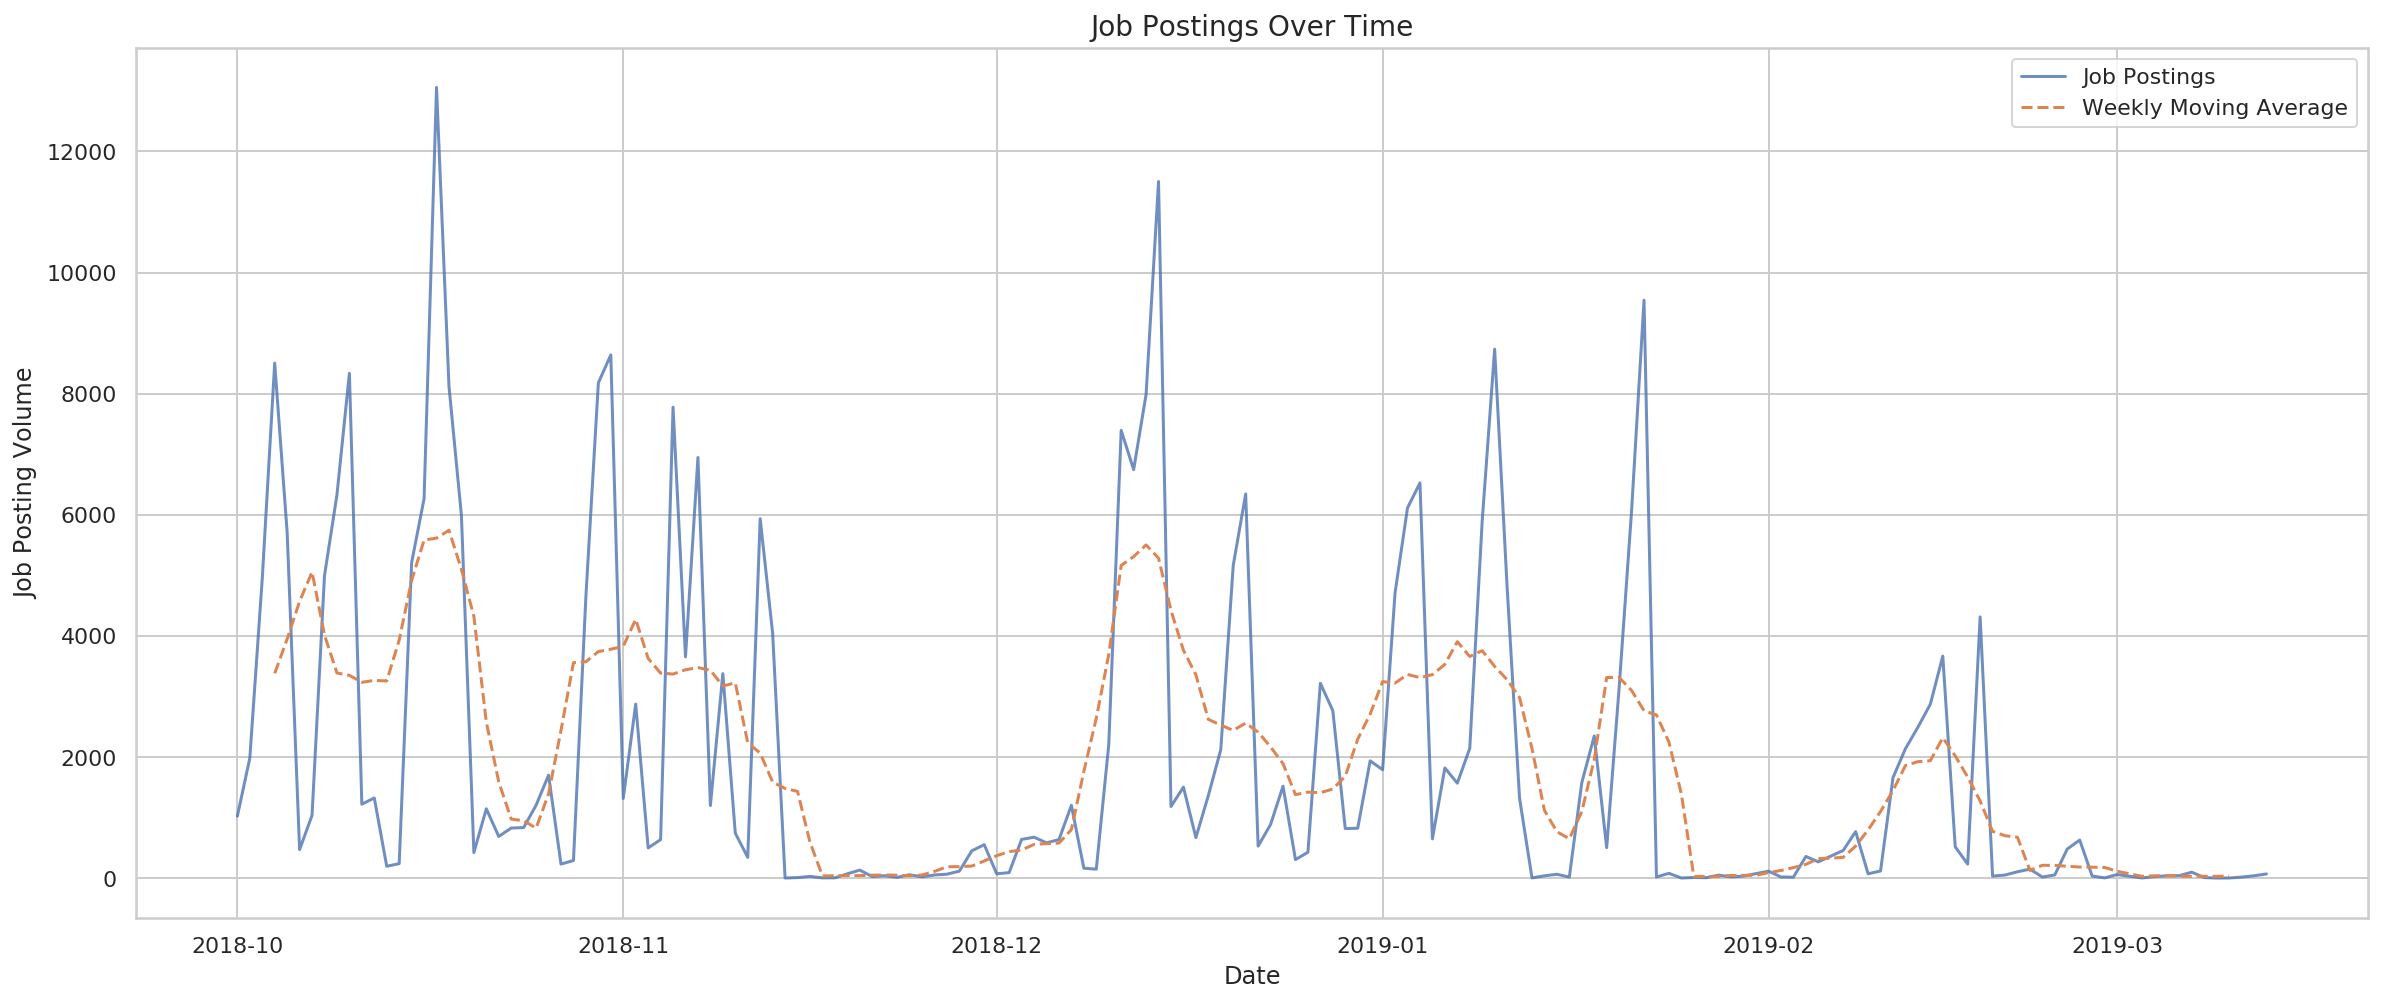

In [27]:
# Set Date column for indexing
df_job_postings = df.groupby(['Date']).count().reset_index().sort_values(by=['Date'])
df_job_postings.set_index('Date',inplace=True)

# Get the count of jobs over time
df_timeseries = df_job_postings['Title'].rename('Count')

# Generate moving average over a weekly interval
moving = df_timeseries.rolling(7, center=True)
data = pd.DataFrame({'Count': df_timeseries, 'Weekly Moving Average': moving.mean()})

plt.figure(figsize=(20,8))
plt.plot(data['Count'],alpha=0.8)
plt.plot(data['Weekly Moving Average'],linestyle='--')
plt.legend(['Job Postings', 'Weekly Moving Average'], frameon=True)
plt.title('Job Postings Over Time',size=14)
plt.xlabel('Date')
plt.ylabel('Job Posting Volume')
plt.show()

### Observation:
* The overall job postings are from Oct 2018 until March 2019
* We can't do much of seasonality analysis because this is not a long period of time
* We do see that there are fluctuations throughout
* There is, however, a really quiet job market from Mid November until begining of December
* The biggest spikes are in Mid October and Mid December

### 2.2 Job postings frequency per Classification

In [34]:
# Get a list of Classifications sorted
list_of_class = df_classification.groupby('Classification').count().reset_index().sort_values(by=['Title'],ascending=False)['Classification'].tolist()

def update(Sector):
    fig = plt.figure(figsize=(20,8))
    axs = fig.add_subplot(111)
    df_current = df_classification[df_classification['Classification'] == Sector].groupby(['Date']).count().reset_index().sort_values(by=['Date'])
    df_current.set_index('Date',inplace=True)
    df_timeseries = df_current['Title'].rename('Count')

    axs.plot(df_timeseries,alpha=0.8,c=np.random.rand(3,))
    axs.set(xlabel='Date', ylabel='Job Posting Volume',title='Job Postings for {0} {1}'.format(Sector, 'Sector'))
    axs.title.set_fontsize(18)

    # Beautify
    fig.autofmt_xdate()
    plt.ylim([0,1500])
    plt.show()
    
interact(update,Sector=list_of_class)

interactive(children=(Dropdown(description='Sector', options=('Information & Communication Technology', 'Trade…

<function __main__.update(Sector)>

### Observations
* We can see the top sectors follow the same pattern that we mentioned above (which makes sense because they make the most job postings)

### 2.3. Job postings frequency per City

In [36]:
# Get a list of Locations sorted by the number of job postings
list_of_class = df_classification.groupby('Location').count().reset_index().sort_values(by=['Title'],ascending=False)['Location'].tolist()
# Get interactive
def update(Location):
    fig = plt.figure(figsize=(20,8))
    axs = fig.add_subplot(111)
    df_current = df_classification[df_classification['Location'] == Location].groupby(['Date']).count().reset_index().sort_values(by=['Date'])
    df_current.set_index('Date',inplace=True)
    df_timeseries = df_current['Title'].rename('Count')

    axs.plot(df_timeseries,alpha=0.8,c=np.random.rand(3,))
    axs.set(xlabel='Date', ylabel='Job Posting Volume',title='Job Postings for {0}'.format(Location))
    axs.title.set_fontsize(18)

    # Beautify
    fig.autofmt_xdate()
    plt.ylim([0,4000])
    plt.show()
interact(update,Location=list_of_class)

interactive(children=(Dropdown(description='Location', options=('Sydney', 'Melbourne', 'Brisbane', 'Perth', 'A…

<function __main__.update(Location)>

### 2.4 Job postings frequency of all Cities

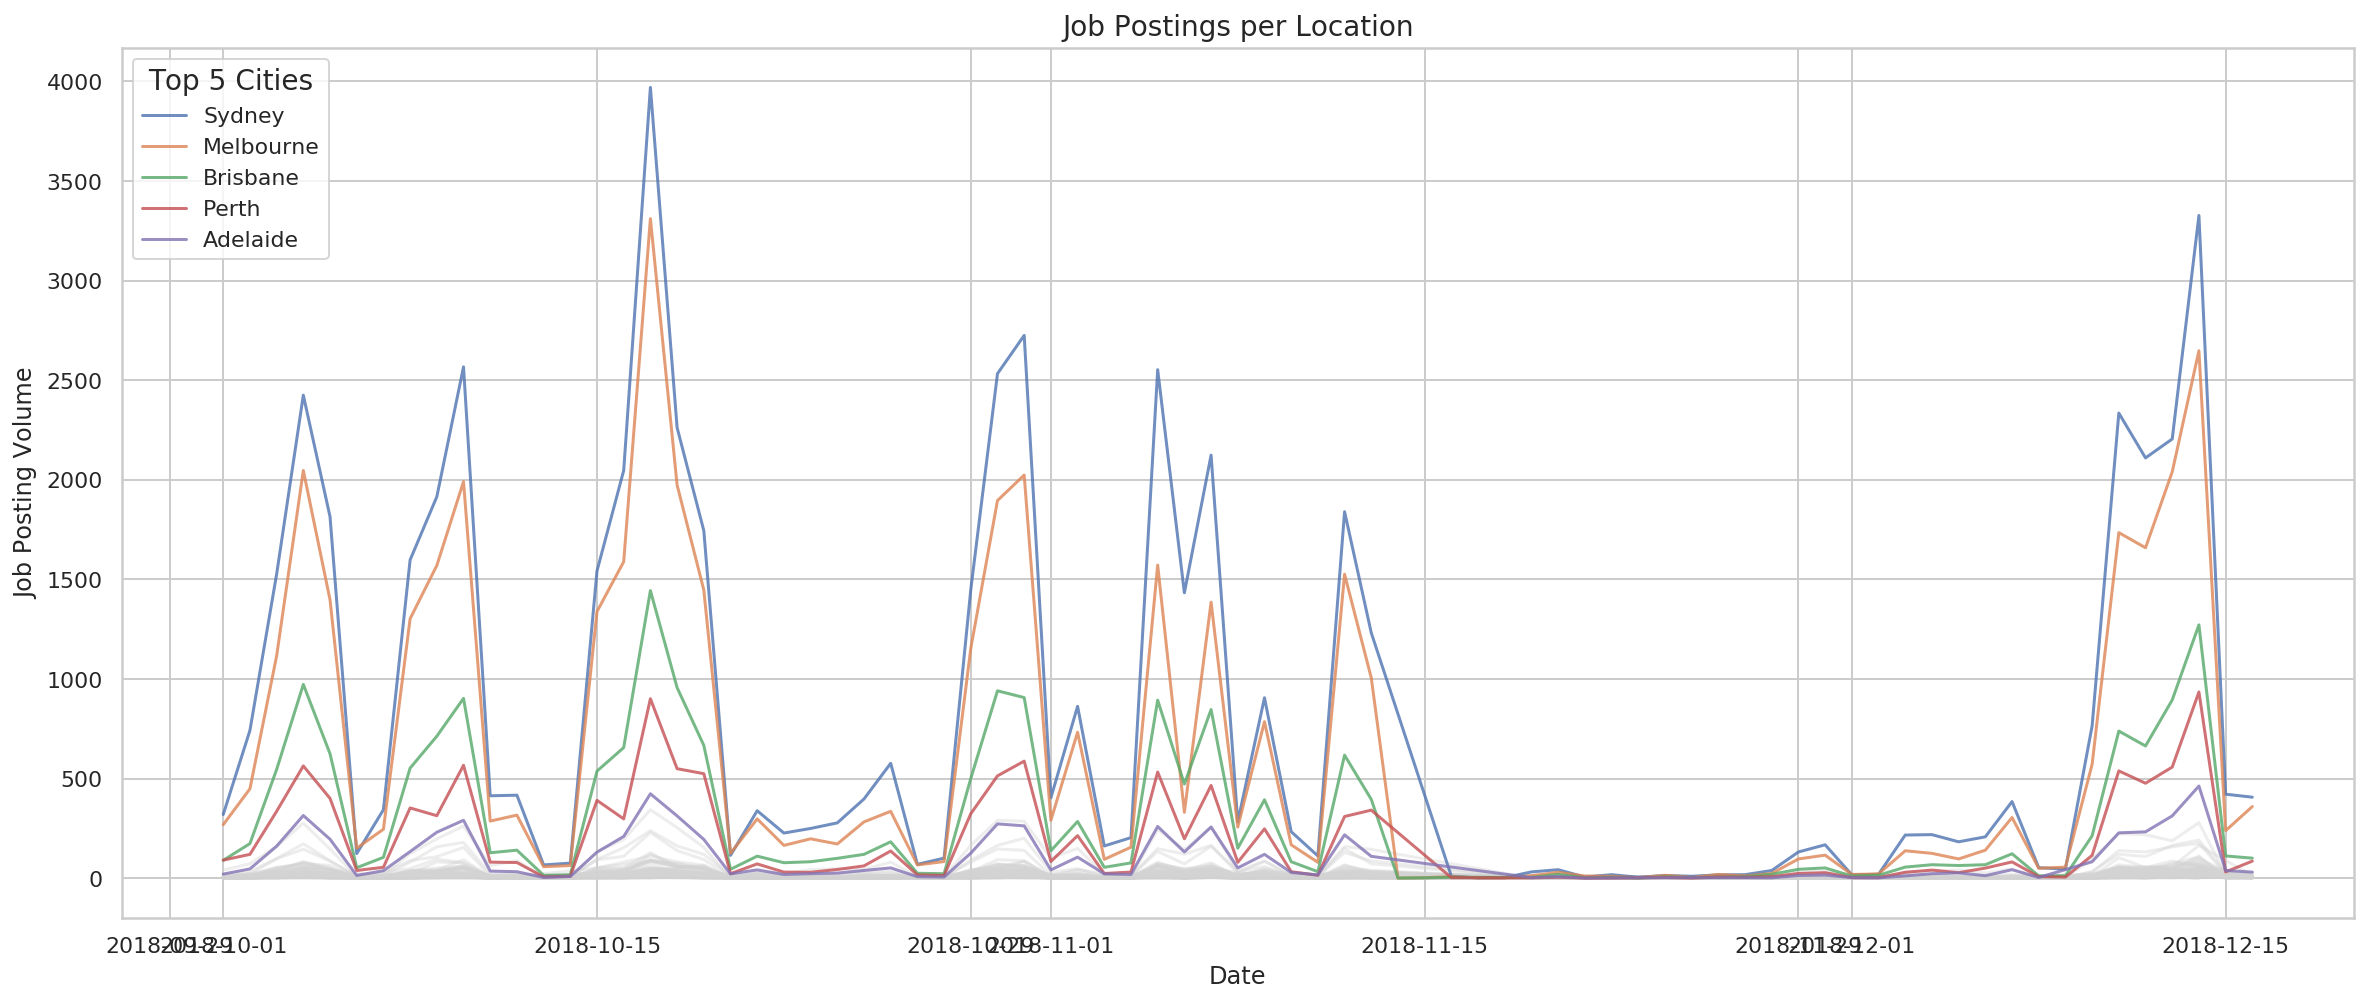

In [37]:
plt.figure(figsize=(20,8))

# Get job counts per location
df_location_cnts = df_location.groupby('Location').count().reset_index()
df_location_top = df_location_cnts.sort_values(by=['Title'],ascending=False)['Location'].tolist()

# Plot top 5 in different colors
for location in df_location_top[:5]:
    df_current = df[df['Location'] == location].groupby(['Date']).count().reset_index().sort_values(by=['Date'])
    df_current.set_index('Date',inplace=True)
    
    df_timeseries = df_current['Title'].rename('Count')

    plt.plot(df_timeseries,alpha=0.8,zorder=2)

# Plot the rest in light grey
for location in df_location_top[5:]:
    df_current = df_location[df_location['Location'] == location].groupby(['Date']).count().reset_index().sort_values(by=['Date'])
    df_current.set_index('Date',inplace=True)
    
    df_timeseries = df_current['Title'].rename('Count')

    plt.plot(df_timeseries,alpha=0.4,c='lightgrey',zorder=1)
    
plt.legend(df_location_top[:5], title='Top 5 Cities', frameon=True)
plt.title('Job Postings per Location',size=14)
plt.xlabel('Date')
plt.ylabel('Job Posting Volume')
plt.show()

### Observations:
* 5 biggest cities produce 75% of the job market

In [56]:
df_description = df_classification[df_classification['FullDescription'].isna()==False]
TAG_RE = r'<[^>]+>'
another = r'nbsp'
another1 = r'\&|\*|\;'
final = re.compile('{}|{}|{}'.format(TAG_RE,another,another1))
def remove_tags(text):
    text = final.sub('', text)

    return text

# Parse HTML formatted descriptions
df_description['FullDescription'] = df_description['FullDescription'].apply(remove_tags)
df_description['FullDescription'] = df_description['FullDescription'].apply(lambda x: x.strip('&nbsp'))
df_description['FullDescription'] = df_description['FullDescription'].apply(lambda x: x.strip('\n'))

Title  \
121                               Fabricator/Installer   
122                                        Boilermaker   
123            Relationship Manager - Industry Banking   
124            Relationship Manager - Industry Banking   
125       Casual Childcare Positions  | Bondi Junction   
126                                         Technician   
127                                   Systems Engineer   
128                                    Project Officer   
129                 SENIOR MARKETING & PRODUCT MANAGER   
130                        Operations Delivery Manager   
131                                    General Manager   
132                                    General Manager   
133  Technical Support Executive - $70K + Super - C...   
134                    Compensation & Benefits Manager   
135          Intermediate Business Services Accountant   
136  Illustrator - Kids Stationery, Party & Christm...   
137                Senior Business Development Manager   
138                                              Pilot   
139                            Project Officer - Youth   
140             Maintenance and Contractor Coordinator   

                                       Company       Date  \
121                  WORKPLACE ACCESS & SAFETY 2018-10-07   
122                    RPM Contracting QLD P/l 2018-10-07   
123                                     BankSA 2018-10-07   
124                                     BankSA 2018-10-07   
125                            anzuk Education 2018-10-07   
126                Zoom Recruitment & Training 2018-10-07   
127                            Humanised Group 2018-10-07   
128                         Metro South Health 2018-10-07   
129            Credit Repair Australia Pty Ltd 2018-10-07   
130                           Woolworths Group 2018-10-07   
131           Multiple Sclerosis SA and NT Inc 2018-10-07   
132           Multiple Sclerosis SA and NT Inc 2018-10-07   
133                              Command Group 2018-10-07   
134       DHL Supply Chain (Australia) Pty Ltd 2018-10-07   
135                                   Benneaux 2018-10-07   
136                                      Kmart 2018-10-07   
137       Smart Technology Recruitment Pty Ltd 2018-10-07   
138          Broadspectrum (Australia) Pty Ltd 2018-10-07   
139  Department of Family & Community Services 2018-10-07   
140             Journal Student Living Pty Ltd 2018-10-07   

                        Location                               Area  \
121                    Melbourne    Bayside & South Eastern Suburbs   
122                     Brisbane           Southern Suburbs & Logan   
123                     Adelaide                                NaN   
124                       Darwin                                NaN   
125                       Sydney  CBD, Inner West & Eastern Suburbs   
126                       Sydney           South West & M5 Corridor   
127                     Brisbane                CBD & Inner Suburbs   
128                     Brisbane                                NaN   
129                       Sydney           South West & M5 Corridor   
130                       Sydney  CBD, Inner West & Eastern Suburbs   
131                       Sydney  CBD, Inner West & Eastern Suburbs   
132                    Melbourne                CBD & Inner Suburbs   
133                       Sydney  CBD, Inner West & Eastern Suburbs   
134                       Sydney  CBD, Inner West & Eastern Suburbs   
135                    Melbourne                CBD & Inner Suburbs   
136                    Melbourne                                NaN   
137                       Sydney  CBD, Inner West & Eastern Suburbs   
138    Toowoomba & Darling Downs                                NaN   
139  Coffs Harbour & North Coast                                NaN   
140                    Melbourne                CBD & Inner Suburbs   

                             Classification  \
121      

In [52]:
text_series = df_description['FullDescription'] + df_description['Requirement']
text_series.dropna(inplace=True)

## 3. Textual Analysis on Required Skills

The original purpose for textual analysis was to visually examine and potentially identify the common skills required for different job sectors, and how they relate.  The input for the visualisation is a tf-idf analysis on the job requirements and description attributes in the dataset, which finds the most common words of the highest information value.  This was completed using the scikit-learn library and nltk.  Two methods were initially tested for finding words; one with word stemming and the other just using stopwords.  The word stemming didn't really provide enough additional information for the purposes of this analysis to justify its slow performance, so the latter method was used instead.

The final results do provide enough information to differentiate most notable sectors, and will be examined in the observations below.

### 3.1. TF-IDF - Based Analysis on the Entire Market

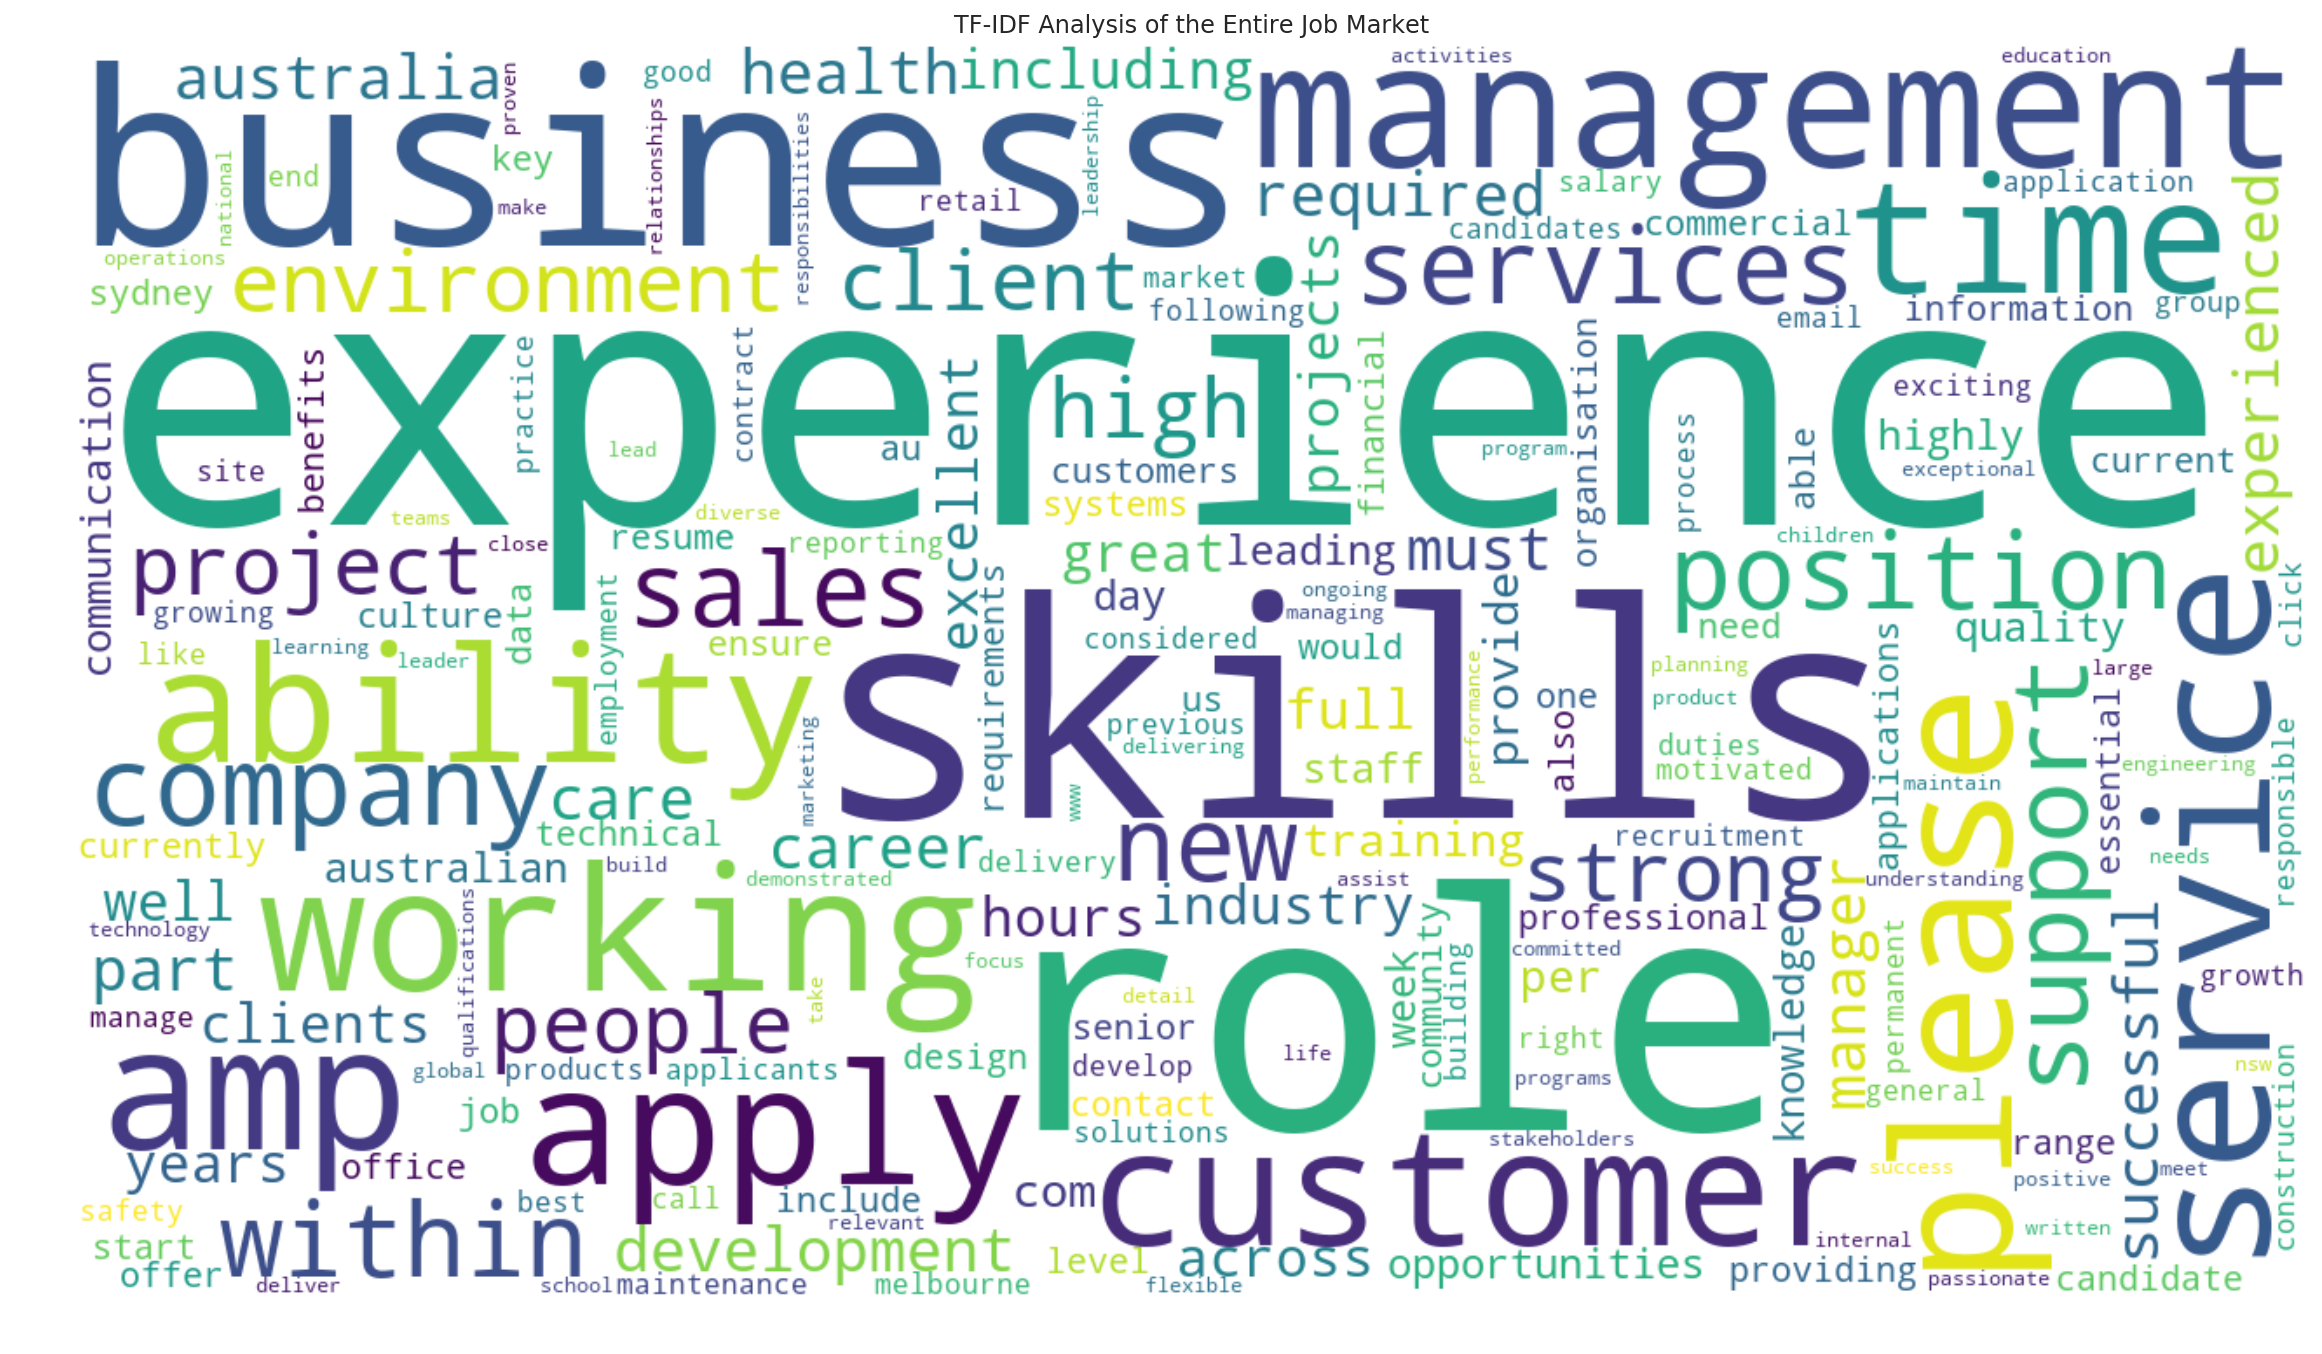

In [71]:
# Stopwords
stop_words = nltk.corpus.stopwords.words('english')

# Adding a hardcoded list of unneccessary things
unnecessary  = ['team','join','looking', 'seeking', 'opportunity', 'available', 'work', 'location','based']
for u in unnecessary:
    stop_words.append(u)
    
# Prepare data for textual analysis
requirements_all = [text.strip() for text in text_series.values]

# Perform tf-idf on entire market
# Takes a while because of the custom stem analyzer
req_analysis = text_analysis.CountVectorizer(stop_words=stop_words,analyzer='word',max_features=200)
req_tf = req_analysis.fit_transform(requirements_all)

# Calculate tf-idf values
req_analysis_transformer = text_analysis.TfidfTransformer(use_idf=True)
req_tfidf = req_analysis_transformer.fit_transform(req_tf)

# Calculate the total for each word after normalization
totals = req_tfidf.sum(axis=0)

# Create list of common terms with their tf-idf sum in order from highest to lowest
freq = sorted([(word, totals[0, i]) for word, i in req_analysis.vocabulary_.items()], key=lambda x: x[1],reverse=True)

# Visualise
# Convert freq list to dict
freq_dict = {x: y for x,y in freq}

freq_dict.items()
word_cloud = wordcloud.WordCloud(width=1280,height=720,background_color='white',colormap='viridis')
word_cloud.generate_from_frequencies(freq_dict)

plt.figure(figsize=(20,20))
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis("off")
plt.title('TF-IDF Analysis of the Entire Job Market')
plt.show()

The textual analysis on the requirements and description columns for the market Australia-wide looks at the most common terms of greatest importance across the entire dataset, irrespective of job sector.  It is a somewhat decent representation of the general rhetoric that is used for any typical advertisement.

### 3.2. TF-IDF - Based Analysis on Job Sectors

In [73]:
# Get a list of classification keys
class_keys = df[df['Classification'].isna() == False]['Classification'].unique()
requirements_dict = dict()
requirements_cnt = dict()

# Iterate over the list of unique classifications, and add the corresponding requirements to a dictionary
for key in class_keys:
    new_data = [data['Requirement'].strip() for index, data in df[(df['Requirement'].isna() == False) & (df['Classification'] == key)].iterrows()]
    requirements_dict[key] = new_data
    requirements_cnt[key] = len(new_data)

# Example requirements
requirements_dict['Retail & Consumer Products'][:5]

['Our Casual Stock Replenishers pride themselves on filling&#8232; shelves faster than anyone else in the industry.',
 'Our Casual Stock Replenishers pride themselves on filling &#8232;shelves faster than anyone else in the industry.',
 'BRAND NEW FLAGSHIP STORE OPENING - SUNSHINE PLAZA',
 'Bring it on - do you love the great outdoors and want to work with like minded people?  We are on the lookout for new team members to join our busines',
 'We currently have an exciting part-time opportunity for a motivated and sales focussed individual to join our team at our Adelaide store.']

In [74]:
# Dictionary of tf-idf values
tf_idf_dict = dict()

# Perform tf-idf on each sector
for key in class_keys:
    req_analyser = text_analysis.CountVectorizer(stop_words=stop_words,analyzer='word',max_features=200)
    req_tf = req_analyser.fit_transform(requirements_dict[key])
    
    # Calculate tf-idf values
    req_analysis_transformer = text_analysis.TfidfTransformer(use_idf=True)
    req_tfidf = req_analysis_transformer.fit_transform(req_tf)
    
    # Calculate the total for each word after normalization
    totals = req_tfidf.sum(axis=0)

    # Create list of common terms with their tf-idf sum in order from highest to lowest, add to dictionary
    freq = sorted([(word, totals[0, i]) for word, i in req_analyser.vocabulary_.items()], key=lambda x: x[1],reverse=True)
    tf_idf_dict[key] = freq

# Plot jobs with highest ad frequencies
select_keys = [x[0] for x in sorted(requirements_cnt.items(), key = lambda x: x[1], reverse = True)]

# Get interactive
def update(Sector):
    fig = plt.figure(figsize=(20,8))
    freq_dict = {x: y for x,y in tf_idf_dict[Sector]}
    
    word_cloud = wordcloud.WordCloud(width=1280,height=720,background_color='white',colormap='viridis')
    word_cloud.generate_from_frequencies(freq_dict)
    
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.title(Sector)
    
    plt.imshow(word_cloud,interpolation='bilinear')
   
interact(update,Sector=select_keys)   

interactive(children=(Dropdown(description='Sector', options=('Information & Communication Technology', 'Trade…

<function __main__.update(Sector)>

### Observations

+ In both Trades & Services and Manufactoring, Transport & Logistics, experience seems to be one of the most important qualities to have.
+ In the ICT sector, a lot of jobs seem to be contractual.